Goal: Create generalized code that can be used to identify submesoscale fronts in a saildrone dataset 

Things to make changeable: 
- what variable can be input
- resampling size
- gradient criteria 

Outputs:
- A dictionary of datasets with front sections? 

Other things to consider:
- should I be using the gradients from least squares approximation to estimate the fronts? 
- What should I pick as the gradient criteria for different variables? 
    - temp, sal, density? 

### Methods 

1. Merge non-adcp and adcp datasets together so they are aligned in both space and time
2. calculate distance between points and drop data where distance is greater than 1km 
3. Remove data where relative distance between saildrones is greater than 5km
4. interpolate data to 0.5 km resolution
5. Pick an along track density gradient percentile range and isolate fronts
6. Postprocess

### Import packages 

In [1]:
# for local use 
import sys
sys.path.append("/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/utilities")
from Utils import *
from ATOMIC_Utils import *
from Gradient_LeastSquares import *

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd
import sys
from matplotlib.colors import LogNorm
import seawater as sw
from sklearn.metrics import pairwise_distances
from scipy import stats
from pycurrents.adcp.rdiraw import Multiread
from sklearn.metrics.pairwise import nan_euclidean_distances

### functions

In [3]:
def CalculateDistance(lon,lat):
    """
    Calculate along-track distance given
        an array of lon,lat.
    Return
        - along-track distance [km]
    """
    return np.hstack([0,np.cumsum(sw.dist(lon=lon,lat=lat,units='km')[0])])

In [4]:
def GetQuantile(data,q):

    """ Calculate desired quantile(s) for density gradient magnitude

    Parameters
    ----------
    data: 1D, array-like 
    q: the desired quantile, number between 0 and 1

    returns:
    q_value: the quantile of the data associated with the desired q input 
    """

    q_value = np.nanquantile(data,q)

    return q_value

In [5]:
def FrontLocationFromQuantile(ds,variable,q=None,qmin=None,qmax=None):

    """Get element-wise location of fronts as defined by a quantile. Return an array of front locations and a xarray dataset with fronts 

    Parameters
    ---------
    ds: xarray dataset
    variable: data for isolating fronts. Xarray data array within ds (e.g. density, salinity, temperature)
    q: quantile value associated with variable (use this if you want the range q to 1 
    qmin: minimum quantile value associated with variable ( use this if you want a specified range qmin to qmax)
    qmax: maximum quantile value associated with variable ( use this if you want a specified range qmin to qmax)

    returns:
    frontlocation: numpy array with element-wise locations of 'fronts' 
    fronts: xarray dataset with only frontal data 
    """

    if qmin and qmax:
        fronts = ds.where((variable >= qmin) & (variable <= qmax), drop=True)
        # locate elementwise where the fronts are - this will give you the values for all drones 
        frontlocation = np.where([(variable >= qmin) & (variable <= qmax)])[2]  # 2 is for order of time dimension
        frontlocation = np.unique(frontlocation)
    
    if q:
    # select data where density diff is greater than or equal to quantile
        fronts = ds.where(variable >= q, drop=True)


    # locate elementwise where the fronts are - this will give you the values for all drones 
        frontlocation = np.where([(variable >= q)])[1]
    # only select elements that are unique (we don't need duplicates)
        frontlocation = np.unique(frontlocation)

    return frontlocation, fronts

In [6]:
def RemoveRepeatFronts(frontlocation,fronts,variable,points=10):
    """
    Return an array with the element-wise locations of repeat fronts. A repeat front is defined as a 
    value that's within a certain distance of the current value

    Parameters
    ----------
    frontlocation: array like, element-wise locations of 'fronts'
    fronts: dataset of fronts
    variable: the variable of interest for estimating fronts (e.g. salinity, temp, sigma0)
    points: number of time points 
    """

    frontlocation_delete = []

    for i in range(len(frontlocation[0:-1])):
        if frontlocation[i+1] <= frontlocation[i] + points:
            print('Repeat Front')
            if fronts.isel(time=i)[variable].max() < fronts.isel(time=i+1)[variable].max():
                frontlocation_delete.append(i)
            else:
                frontlocation_delete.append(i+1)
            
        else:
            print('No Repeat')

    frontlocation_delete = np.unique(frontlocation_delete)

    return frontlocation_delete

In [7]:
def Get_S_Shape(buffer,frontlocation):
    """
    Create a list of xarray datasets - one dataset per front.
    Dataset is created by taking +/- some number of time points centered around
    the middle of the front (where the strongest along-track gradient is)

    Parameters
    ---------
    buffer: number of time points to add before and after center of front
    (e.g. buffer = 10 creates a 10 km section of 0.5km horizontal resolution (+/- 5km on each side)
    frontlocation: array of element-wise location values of front
    """

    dslist_subset = []

    # buffer for how many time points to add before and after each front location
    buffer = buffer
    
    # for loop for taking time slices at each front - results in a list of datasets 
    for value in range(len(frontlocation)):
        dslist_subset.append(subset.isel(time=slice(frontlocation[value]-buffer,frontlocation[value]+buffer)))

    dslists = [dslist_subset]
    for ds_list in dslists:
        for i in range(len(frontlocation)):
                    
            cum_dist = np.hstack([0,np.cumsum(np.diff(ds_list[i].distance))])
            ds_list[i]['distance_cum'] = ('time',cum_dist)

    return dslist_subset

In [8]:
def PostProcess_Fronts(dslist_subset,limit):
    """
    Remove front datasets if there time is greater than some limit. 
    For example, we wouldn't expect a 10 km front to be over 3 hours.

    Parameters
    ----------
    dslist_subset: list of datasets of fronts
    limit: total time limit in hours that the front datasets must not exceed or they get removed
    
    """

    # check if time is alot 
    time_diff = []
    to_remove = []
    for ds in range(len(dslist_subset)):
        diff = (dslist_subset[ds].time[-1] - dslist_subset[ds].time[0]);
        diff = diff.values.astype('timedelta64[h]');
        time_diff.append(diff);
        if diff > np.timedelta64(limit,'h'):
            print(ds)
            to_remove.append(ds)

    for value in sorted(to_remove, reverse=True):
        del dslist_subset[value]

    return dslist_subset

### Step 1. Load data locally 

In [9]:
coefs = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/data/velocitycoefs_and_diagnostics.nc')
coefs_nonadcp =  xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/data/gradients/coefs_nonadcp.nc')
subset = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/DataMackenzie/velocitydata_all_corrected.nc')
# subset_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/DataMackenzie/atomic_nonadcp_merged_1min.nc')  
subset_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/data/frontfinder/nonadcp_5min.nc')

In [10]:
# load merged dataset
subset = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/MergedDS_FrontFinder.nc')

In [59]:
plt.plot(subset1.sel(saildrone='1060').lon,subset1.sel(saildrone='1060').lat);
plt.plot(subset_nonadcp1.sel(saildrone='1060').lon,subset_nonadcp1.sel(saildrone='1060').lat);
plt.plot(subset_nonadcp2.sel(saildrone='1060').lon,subset_nonadcp2.sel(saildrone='1060').lat);

NameError: name 'subset1' is not defined

In [49]:
subset_nonadcp2 = subset_nonadcp1.coarsen(time=5).mean()

In [41]:
adcp = CalculateDistance(subset1.sel(saildrone='1060').lon,subset1.sel(saildrone='1060').lat)
nonadcp = CalculateDistance(subset_nonadcp1.sel(saildrone='1060').lon,subset_nonadcp1.sel(saildrone='1060').lat)

In [40]:
subset1 = subset.sel(time=slice('2020-02-17T08','2020-02-17T12'))
subset_nonadcp1 = subset_nonadcp.sel(time=slice('2020-02-17T08','2020-02-17T12'))

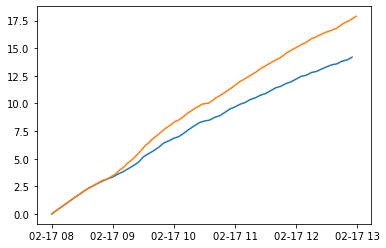

In [42]:
plt.plot(subset1.time,adcp)
plt.plot(subset_nonadcp1.time,nonadcp)

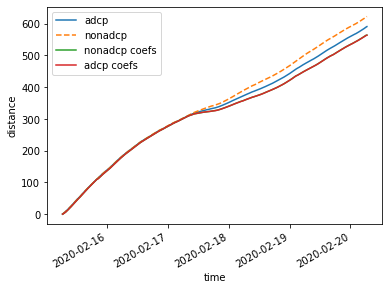

In [9]:
# compare distances - why is there a difference between each dataset ? Is this important to keep track of?
subset.distance.plot(label='adcp')
subset_nonadcp.distance.plot(linestyle='dashed',label='nonadcp')
coefs_nonadcp.distance.plot(label='nonadcp coefs')
allcoefs.distance.plot(label='adcp coefs')
plt.legend()

In [13]:
# load merged dataset
subset = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/MergedDS_FrontFinder.nc')

### Preprocessing 

#### Visualize the SD tracks 

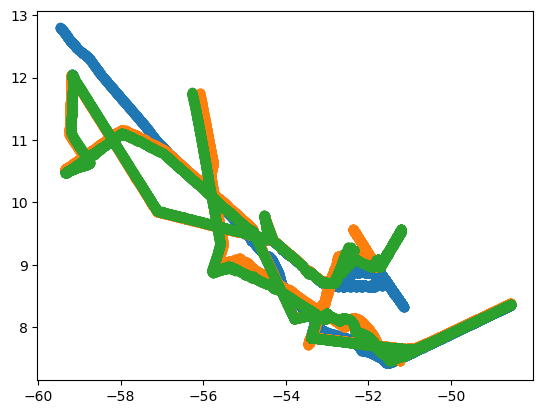

In [12]:
# tracks before removing large relative distances - NON ADCP
plt.scatter(subset_nonadcp.sel(saildrone='1060').longitude, subset_nonadcp.sel(saildrone='1060').latitude)
plt.scatter(subset_nonadcp.sel(saildrone='1061').longitude, subset_nonadcp.sel(saildrone='1061').latitude)
plt.scatter(subset_nonadcp.sel(saildrone='1026').longitude, subset_nonadcp.sel(saildrone='1026').latitude)

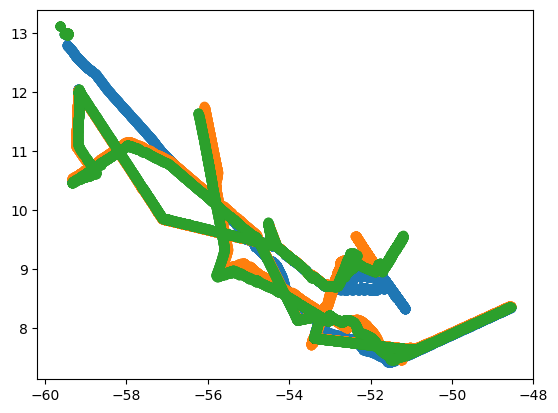

In [13]:
# tracks before removing large relative distances - ADCP 
plt.scatter(subset.sel(saildrone='1060').longitude, subset.sel(saildrone='1060').latitude)
plt.scatter(subset.sel(saildrone='1061').longitude, subset.sel(saildrone='1061').latitude)
plt.scatter(subset.sel(saildrone='1026').longitude, subset.sel(saildrone='1026').latitude)

#### Merge non adcp and adcp data so they are aligned in space and time 

In [14]:
# select data from nonadcp that we want so we dont have to deal with stupid large dataset 
var_list = ['TEMP_SBE37_MEAN','sigma0','relative_distance','SAL_SBE37_MEAN',]

subset_nonadcp = subset_nonadcp[var_list]

In [15]:
# align time - select nonadcp data where time are same as adcp data 
subset_nonadcp = subset_nonadcp.where(subset_nonadcp.time == subset.time, drop=True)

In [16]:
# do the same with adcp 
subset = subset.where(subset.time == subset_nonadcp.time, drop=True)

In [17]:
# transpose to reorder dimensions 
subset_nonadcp = subset_nonadcp.transpose()

In [18]:
# assign coordinates to adcp data
subset = subset.assign_coords({'latitude':subset.latitude,'longitude':subset.longitude})

In [19]:
# merge the two datasets together so we ensure there is the same space and time 
# not sure if compat = 'override' is the right thing to be doing, may need to double check this later 
subset = xr.merge([subset,subset_nonadcp],compat='override')

In [20]:
subset

<xarray.Dataset>
Dimensions:            (saildrone: 3, time: 13239, depth: 50)
Coordinates:
    latitude           (saildrone, time) float64 nan nan nan ... 9.187 9.19
    longitude          (saildrone, time) float64 nan nan nan ... -52.01 -52.01
  * saildrone          (saildrone) <U4 '1026' '1060' '1061'
  * time               (time) datetime64[ns] 2020-01-17 ... 2020-03-02T23:55:00
  * depth              (depth) float64 4.24 6.24 8.24 ... 98.24 100.2 102.2
Data variables:
    u                  (saildrone, time, depth) float64 nan nan ... -0.079 0.087
    v                  (saildrone, time, depth) float64 nan nan ... -0.321
    w                  (saildrone, time, depth) float64 nan nan ... -0.175 0.079
    e                  (saildrone, time, depth) float64 nan nan ... 0.003 0.0
    TEMP_SBE37_MEAN    (saildrone, time) float64 27.36 27.35 ... 26.86 26.83
    sigma0             (saildrone, time) float64 22.72 22.72 ... 23.49 23.49
    relative_distance  (saildrone, time) float64 408.3 408.3 ... 114.1 115.2
    SAL_SBE37_MEAN     (saildrone, time) float64 35.32 35.31 ... 36.14 36.13

#### Step 3. Calculate distances (between points and cumulative)

In [21]:
# calculate buoyancy 

## you should always use 1025! 
rho_0 = 1025
rho_anom = subset.sigma0 - subset.sigma0.mean()
b = 9.82 * (rho_anom / rho_0)


# add buoyancy variable to dataset 
subset['b'] = b


# one thing I need to check is if there are large gaps in time / distance that will make rho diff large 
rho_diff = subset.sigma0.diff(dim='time')

subset['rho_diff'] = rho_diff




# calculate magnitude of rho_diff
rho_diff_mag = np.absolute(subset.rho_diff)

# add to dataset 
subset['rho_diff_mag'] = (('saildrone','time'),rho_diff_mag.data)

In [22]:
# calculate relative distance between drones 
# this block of code is from Cesar's DensityGradients notebook
# pairwise_distances function is not working because of nans
# will try another function (replaced pairwise_distances with nan_euclidean_distances)

# paralellize this this loop
for i in range(subset.time.size):

    data = subset.isel(time=i)

    theta = data.latitude*np.pi/180

    X=np.vstack([data.longitude/np.cos(theta),data.latitude]).T # CHECK THIS, and note that this is a small angle approximation.
    
    if i == 0:
        dist = 112*nan_euclidean_distances(X)[np.newaxis] # distance matrix in km
    else:
        dist = np.vstack([dist,112*nan_euclidean_distances(X)[np.newaxis]])
        
dd = np.vstack([dist[:,0,1],dist[:,0,2],dist[:,1,2]])

In [23]:
# add relative distance to dataset 
subset['relative_dist'] = (['saildrone','time'],dd)

# define radius parameter 
# parameters
DR = 5             # radius in km

# keep only that whose max(relative_distance)<=DR
subset = subset.where(np.max(subset.relative_dist,axis=0)<=DR,drop=True)
# subset_nonadcp = subset_nonadcp.where(np.max(subset.relative_dist,axis=0)<=DR,drop=True)

In [24]:
# calculate distance difference between points and add to dataset - ADCP data 
dist_diff1060 = xr.DataArray(np.hstack([0,sw.dist(subset.sel(saildrone='1060').longitude, subset.sel(saildrone='1060').latitude)[0]]),
                             coords={'time':subset.time},
                             dims=['time'])
dist_diff1061 = xr.DataArray(np.hstack([0,sw.dist(subset.sel(saildrone='1061').longitude, subset.sel(saildrone='1061').latitude)[0]]),
                             coords={'time':subset.time},
                             dims=['time'])
dist_diff1026 = xr.DataArray(np.hstack([0,sw.dist(subset.sel(saildrone='1026').longitude, subset.sel(saildrone='1026').latitude)[0]]),
                             coords={'time':subset.time},
                             dims=['time'])

# concat all data arrays by saildrone dimension
dist_diff_adcp = xr.concat([dist_diff1026,dist_diff1060,dist_diff1061],dim=subset.saildrone)

# add to adcp dataset 
subset['distance_diff'] = (['saildrone','time'],dist_diff_adcp.data)

In [25]:
# drop all values where distance between points is large (in this case, greater than 1km) 
# Q: is 1km a reasonable distance between points - should this be smaller??? 

# subset_nonadcp = subset_nonadcp.where(subset_nonadcp.distance_diff < 1, drop=True)

subset = subset.where(subset.distance_diff < 1, drop=True)

In [26]:
# drop nans from longitude to be able to calculate distance - Calc distance function does not work with nans in it 
lon_nonan = subset.longitude.dropna(dim='time')
subset = subset.sel(time=lon_nonan.time)

In [27]:
# only select non adcp data that matches adcp time 
subset_nonadcp = subset_nonadcp.sel(time=subset.time)

In [28]:
# calculate cumulative distance for each SD (ADCP + non ADCP data) 

subset_dist1060 = xr.DataArray(CalculateDistance(lon = subset.sel(saildrone='1060').longitude, 
                               lat = subset.sel(saildrone='1060').latitude),
                           coords={'time':subset.time},
                           dims=['time'])
subset_dist1061 = xr.DataArray(CalculateDistance(lon = subset.sel(saildrone='1061').longitude, 
                               lat = subset.sel(saildrone='1061').latitude),
                           coords={'time':subset.time},
                           dims=['time'])
subset_dist1026 = xr.DataArray(CalculateDistance(lon = subset.sel(saildrone='1026').longitude, 
                               lat = subset.sel(saildrone='1026').latitude),
                           coords={'time':subset.time},
                           dims=['time'])

In [29]:
# concat and add cumulative distances to datasets 
subset_dist = xr.concat([subset_dist1026,subset_dist1060,subset_dist1061],dim=subset.saildrone)
subset['distance_cum'] = (['saildrone','time'],subset_dist.data)

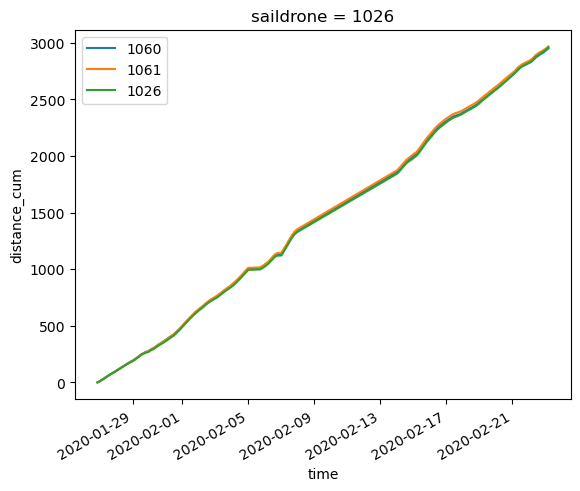

In [30]:
# plots of cumulative distances 
subset.sel(saildrone='1060').distance_cum.plot(label='1060')
subset.sel(saildrone='1061').distance_cum.plot(label='1061')
subset.sel(saildrone='1026').distance_cum.plot(label='1026')
plt.legend()

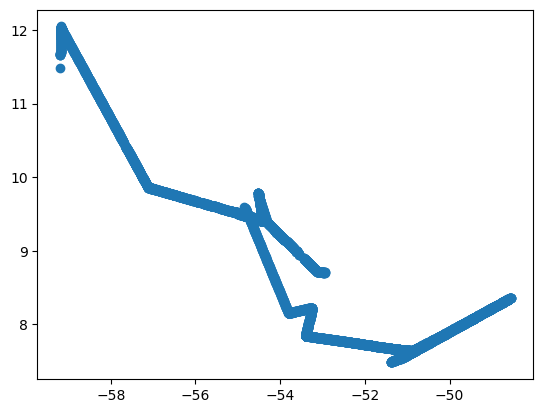

In [31]:
# plt.scatter(subset_nonadcp.sel(saildrone='1060').longitude,subset_nonadcp.sel(saildrone='1060').latitude)
plt.scatter(subset.sel(saildrone='1060').longitude,subset.sel(saildrone='1060').latitude)

In [32]:
# make 1D distance variable to add to datasets - this is necessary in order to swap dims and do interpolation 
subset_dist1060 = xr.DataArray(CalculateDistance(lon = subset.sel(saildrone='1060').longitude, 
                               lat = subset.sel(saildrone='1060').latitude),
                           coords={'time':subset.time},
                           dims=['time'])

subset['distance'] = ('time',subset_dist1060.data)

# subset_nonadcp_dist1060 = xr.DataArray(CalculateDistance(lon = subset_nonadcp.sel(saildrone='1060').longitude, 
#                                lat = subset_nonadcp.sel(saildrone='1060').latitude),
#                            coords={'time':subset_nonadcp.time},
#                            dims=['time'])

# subset_nonadcp['distance'] = ('time',subset_nonadcp_dist1060.data)

#### Step 3. Swap dims (replace time with distance cumulative), and interpolate distance onto evenly spaced grid) 

In [33]:
# make distance the dimension 
# subset_nonadcp = subset_nonadcp.swap_dims({'time':'distance'})
subset = subset.swap_dims({'time':'distance'})

In [35]:
subset.distance_diff.mean()

<xarray.DataArray 'distance_diff' ()>
array(0.34786269)

In [37]:
# subset.to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/MergedDS_FrontFinder.nc')

### The Interpolation

In [11]:
# ---------- PARAMETERS ----------------

dx = 0.5   # distance spacing in km for the interpolation 

In [12]:
# max distance - compare ADCP and non ADCP
print(f'The total cumulative distance for ADCP data is {subset.distance.max().values} km'  )
# print(f'The total cumulative distance for non ADCP data is {subset_nonadcp.distance.max().values} km'  )

print(f'The max distance between points for ADCP data is {subset.distance_diff.max().values} km'  )
# print(f'The max distance between points for non ADCP data is {subset_nonadcp.distance_diff.max().values} km'  )


The total cumulative distance for ADCP data is 2949.968632252519 km
The max distance between points for ADCP data is 0.9631079163740881 km


In [13]:
# # make time a float value (int64) * this is necessary for interpolating time * 
subset['time_int'] = ('distance',pd.to_datetime(subset['time'].values).astype(np.int64))
subset = subset.reset_coords(names=['latitude','longitude','time'])

In [14]:
# create evenly spaced distance array [km] to use for interpolation 
dist_even = np.arange(0,subset.distance[-1].values,dx)     # create the evenly spaced distance array 

# make into xarray data array 
d = xr.DataArray(dist_even,dims='distance')

In [15]:
# the interpolation 
subset = subset.interp(distance=d)
# subset_nonadcp = subset_nonadcp.interp(distance=d)

In [16]:
# redefine the time variable as the interpolated time_int variable defined above
# this is the time that actually got interpolated - we convert back to datetime format here 
subset['time'] = ('distance',pd.to_datetime(subset.time_int.values))

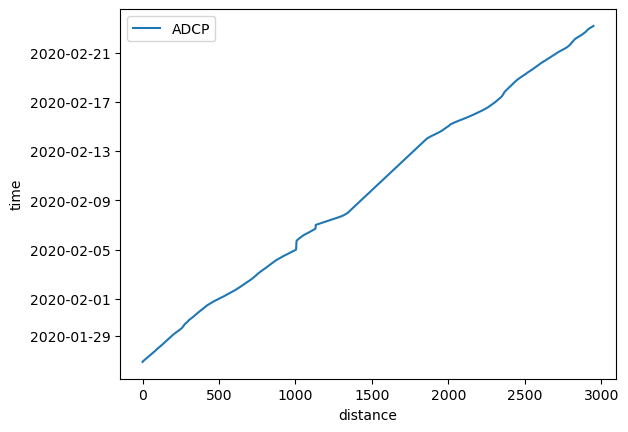

In [17]:
#  confirm time is good 
subset.time.plot(label='ADCP')
plt.legend()

In [18]:
# swap dimensions back 
subset = subset.swap_dims({'distance':'time'})


### PDFs of rho gradients from along-track differentiation and least squares fit 

(0.01, 0.052500000000000005)

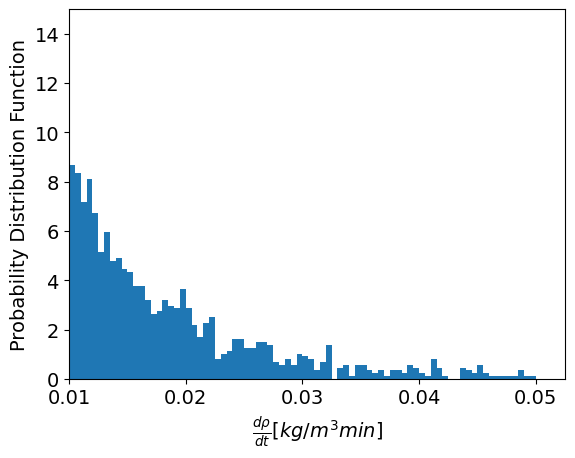

In [28]:
# PDF of along-track difference in rho
plt.rcParams.update({'font.size': 14})
dbins, bmin, bmax = 0.0005, 0, 0.05
plt.hist(subset.rho_diff_mag.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins));
plt.ylabel('Probability Distribution Function')
plt.xlabel(r'$\frac{d\rho}{dt} [kg/m^3min]$')
plt.ylim(0,15)
plt.xlim(0.01)

In [29]:
# calculate rho magnitude from coefs 
rho_mag = np.sqrt(coefs_nonadcp.rhox**2 + coefs_nonadcp.rhoy**2)
rho_mag

<xarray.DataArray (time: 5998)>
array([1.64866850e-06, 1.26040995e-06, 1.49497727e-06, ...,
       1.86851185e-05, 1.86851185e-05, 1.86851185e-05])
Coordinates:
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.95
    latitude   (time) float64 7.502 7.503 7.503 7.503 ... 8.718 8.718 8.718
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00

Text(0.5, 0, '$\\frac{d\\rho}{dl} [kg/m^4]$')

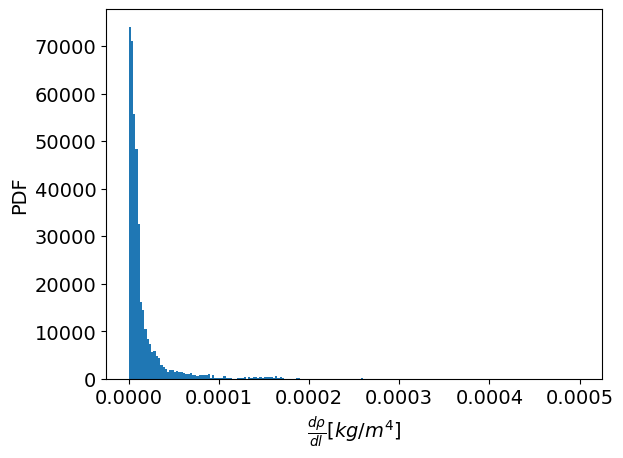

In [30]:
# need to figure out why this estimate is two orders of mag less than above 
dbins, bmin, bmax = 0.0000025, 0, 0.0005
plt.hist(rho_mag.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins));
plt.ylabel('PDF')
plt.xlabel(r'$\frac{d\rho}{dl} [kg/m^4]$')
# plt.ylim(0,3000)


### Calculate desired quantiles and quartiles 

In [19]:
qmax = GetQuantile(data=subset.rho_diff_mag.values.flatten(),q=1)
qmax

0.20974459440707824

In [20]:
qmin = GetQuantile(data=subset.rho_diff_mag.values.flatten(),q=0.9)
qmin

0.007897113199958838

### Calculate location of points within a defined quantile range - this is "front location" 

In [21]:
# get element-wise position of points in between qunatile range 
frontlocation,fronts = FrontLocationFromQuantile(ds=subset,variable=subset.rho_diff_mag, q=None,qmin=qmin,qmax=qmax)
frontlocation

array([  70,   72,  287,  288,  293,  294,  296,  297,  306,  362,  363,
        364,  366,  367,  368,  369,  370,  372,  969, 1048, 1119, 1128,
       1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328,
       1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339,
       1340, 1341, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823,
       1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834,
       1835, 1836, 1837, 1841, 1844, 1845, 1846, 1847, 1848, 1849, 1850,
       1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878,
       1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1904,
       1906, 1915, 1919, 1921, 1922, 1925, 1926, 1928, 1930, 1931, 1934,
       1936, 1939, 1940, 1941, 1942, 1944, 1947, 1948, 1952, 1953, 1958,
       1959, 1960, 1961, 1965, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 19

In [22]:
len(frontlocation)

920

In [23]:
# initialize frontlocation_delete
frontlocation_delete = RemoveRepeatFronts(frontlocation,fronts,variable='rho_diff_mag',
                                          points=10)

# use while loop to repeat the delete process until there are no repeat fronts 
while len(frontlocation_delete) > 0:
    frontlocation_delete = RemoveRepeatFronts(frontlocation,fronts,variable='rho_diff_mag',
                                              points=10)
    frontlocation = np.delete(frontlocation,frontlocation_delete)

Repeat Front
No Repeat
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
No Repeat
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
No Repeat
No Repeat
No Repeat
Repeat Front
No Repeat
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
No Repeat
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat Front
Repeat 

IndexError: arrays used as indices must be of integer (or boolean) type

In [24]:
len(frontlocation)

86

In [25]:
dslist_subset = Get_S_Shape(buffer=10,frontlocation=frontlocation)

In [26]:
dslist_subset[4]

<xarray.Dataset>
Dimensions:            (saildrone: 3, time: 20, depth: 50)
Coordinates:
  * saildrone          (saildrone) <U4 '1026' '1060' '1061'
  * depth              (depth) float64 4.24 6.24 8.24 ... 98.24 100.2 102.2
    distance           (time) float64 519.0 519.5 520.0 ... 527.5 528.0 528.5
  * time               (time) datetime64[ns] 2020-02-01T02:55:20.696486912 .....
Data variables: (12/17)
    u                  (saildrone, time, depth) float64 -0.5445 ... -0.095
    v                  (saildrone, time, depth) float64 0.06107 ... 0.102
    w                  (saildrone, time, depth) float64 -0.02003 ... -0.118
    e                  (saildrone, time, depth) float64 -0.008551 ... -0.001
    TEMP_SBE37_MEAN    (saildrone, time) float64 26.86 26.88 ... 26.83 26.82
    sigma0             (saildrone, time) float64 23.64 23.63 ... 23.62 23.62
    ...                 ...
    relative_dist      (saildrone, time) float64 2.51 2.585 ... 4.608 4.386
    distance_diff      (saildrone, time) float64 0.419 0.4655 ... 0.3841 0.3895
    latitude           (saildrone, time) float64 8.126 8.123 ... 8.121 8.118
    longitude          (saildrone, time) float64 -49.32 -49.32 ... -49.4 -49.4
    distance_cum       (time) float64 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5
    time_int           (time) float64 1.581e+18 1.581e+18 ... 1.581e+18

In [27]:
# # run this if time = 0 - this will happen for the first and last 9 time points of the SD dataset because I am doing the +/- 10
# to_remove = []
# for ds in range(len(dslist_subset)):
#     if dslist_subset[ds].time.any() == 0:
#         print(ds)
#         to_remove.append(ds)

# # ***** IF THE ABOVE CODE RETURNS VALUES, THEN UNCOMMENT BELOW AND RUN AGAIN - THESE POINTS NEED TO BE REMOVED BECAUSE TIME = 0 *****

# for value in sorted(to_remove, reverse=True):
#     del dslist_nonadcp[value]
#     del dslist_subset[value]

# frontlocation = np.delete(frontlocation,to_remove)

### Visualize the fronts 

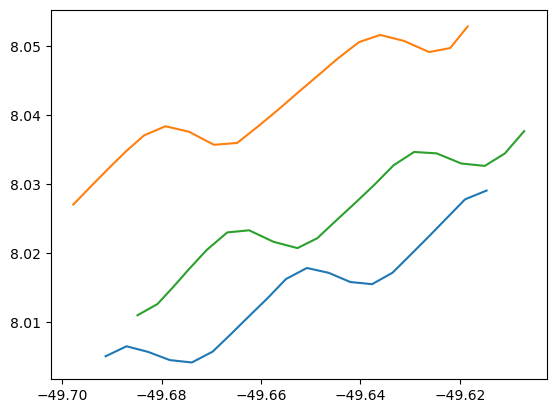

In [28]:
# plt.plot(dslist_nonadcp[50].sel(saildrone='1060').longitude,dslist_nonadcp[2].sel(saildrone='1060').latitude,label='1060')
# plt.plot(dslist_nonadcp[50].sel(saildrone='1061').longitude,dslist_nonadcp[2].sel(saildrone='1061').latitude,label='1061')
# plt.plot(dslist_nonadcp[50].sel(saildrone='1026').longitude,dslist_nonadcp[2].sel(saildrone='1026').latitude,label='1026')


plt.plot(dslist_subset[5].sel(saildrone='1060').longitude,dslist_subset[5].sel(saildrone='1060').latitude,label='1060')
plt.plot(dslist_subset[5].sel(saildrone='1061').longitude,dslist_subset[5].sel(saildrone='1061').latitude,label='1061')
plt.plot(dslist_subset[5].sel(saildrone='1026').longitude,dslist_subset[5].sel(saildrone='1026').latitude,label='1026')


# plt.plot(dslist_nonadcp[2].longitude,dslist_nonadcp[2].sel(saildrone='1061').latitude,label='1061')
# plt.plot(dslist_nonadcp[2].longitude,dslist_nonadcp[2].sel(saildrone='1026').latitude,label='1026')

Text(0, 0.5, 'Potential Density $[kg/m^3]$')

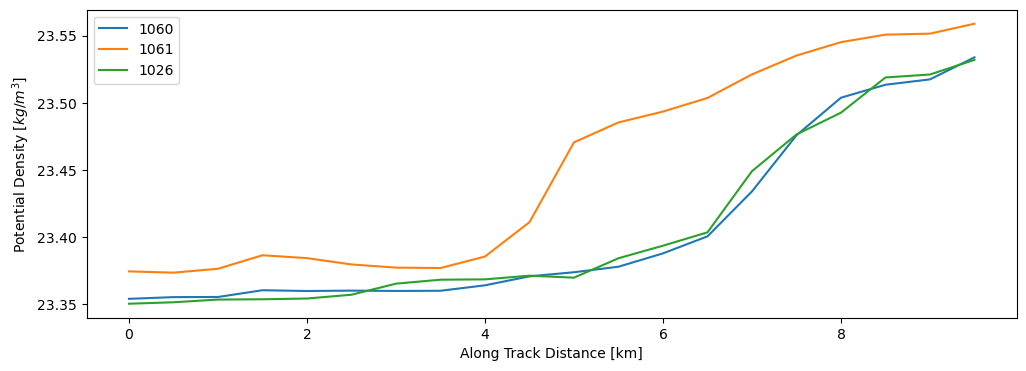

In [29]:
# plot of first front dataset to show differences between saildrone tracks 
figure = plt.figure(figsize=(12,4))
plt.plot(dslist_subset[2].distance_cum,dslist_subset[2].sel(saildrone='1060').sigma0,label='1060')
plt.plot(dslist_subset[2].distance_cum,dslist_subset[2].sel(saildrone='1061').sigma0,label='1061')
plt.plot(dslist_subset[2].distance_cum,dslist_subset[2].sel(saildrone='1026').sigma0,label='1026')
plt.legend()
plt.xlabel('Along Track Distance [km]')
plt.ylabel(r'Potential Density $[kg/m^3]$')

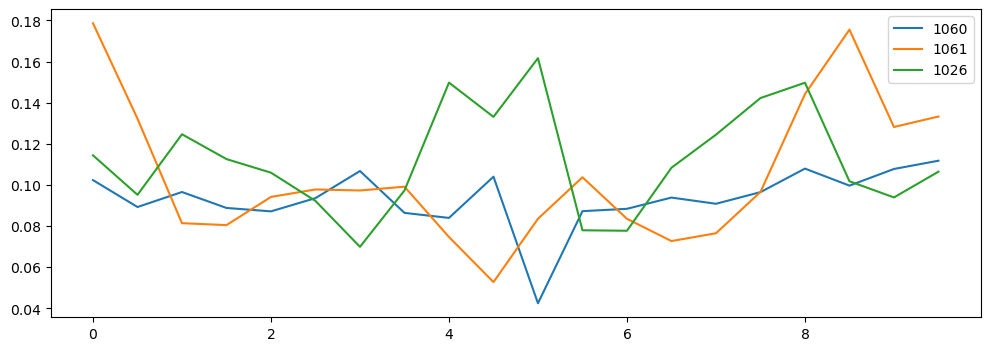

In [30]:
# plot of first front dataset to show differences between saildrone tracks 
figure = plt.figure(figsize=(12,4))
plt.plot(dslist_subset[0].distance_cum,dslist_subset[0].sel(saildrone='1060').isel(depth=0).u,label='1060')
plt.plot(dslist_subset[0].distance_cum,dslist_subset[0].sel(saildrone='1061').isel(depth=0).u,label='1061')
plt.plot(dslist_subset[0].distance_cum,dslist_subset[0].sel(saildrone='1026').isel(depth=0).u,label='1026')
plt.legend()

Text(0, 0.5, 'Potential Density $[kg/m^3]$')

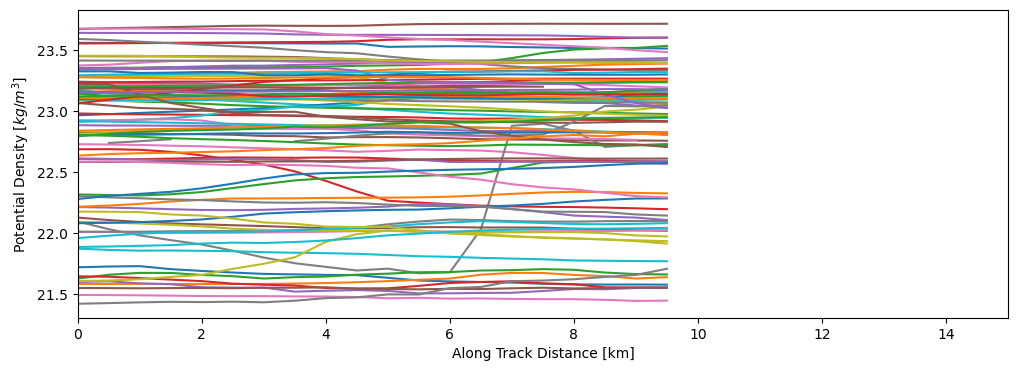

In [31]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(dslist_subset)):
    plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1060').sigma0)
plt.xlim(0,15)
plt.xlabel('Along Track Distance [km]')
plt.ylabel(r'Potential Density $[kg/m^3]$')

In [32]:
# calculate density anomaly and plot that 
for ds in range(len(dslist_subset)):
    dslist_subset[ds]['sigma_anom'] = dslist_subset[ds].sigma0 - dslist_subset[ds].sigma0.mean()
# dslist_nonadcp[0].sigma0.mean()

Text(0, 0.5, 'Potential Density Anomaly $[kg/m^3]$')

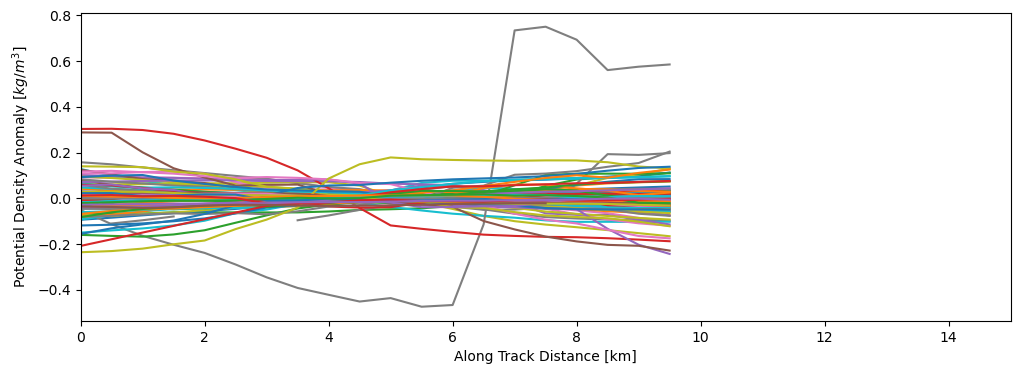

In [33]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(dslist_subset)):
    plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1060').sigma_anom)
plt.xlim(0,15)
plt.xlabel('Along Track Distance [km]')
plt.ylabel(r'Potential Density Anomaly $[kg/m^3]$')
# plt.ylim(-0.4,0.4)

### Step 8. Post-processing the fronts - need to remove fronts that have distance > 10km and a long time range (> 3hr)

In [34]:
dslist_subset = PostProcess_Fronts(dslist_subset,limit=3)

17
27
63
64


In [35]:
len(dslist_subset)

82

Text(0, 0.5, 'Potential Density $[kg/m^3]$')

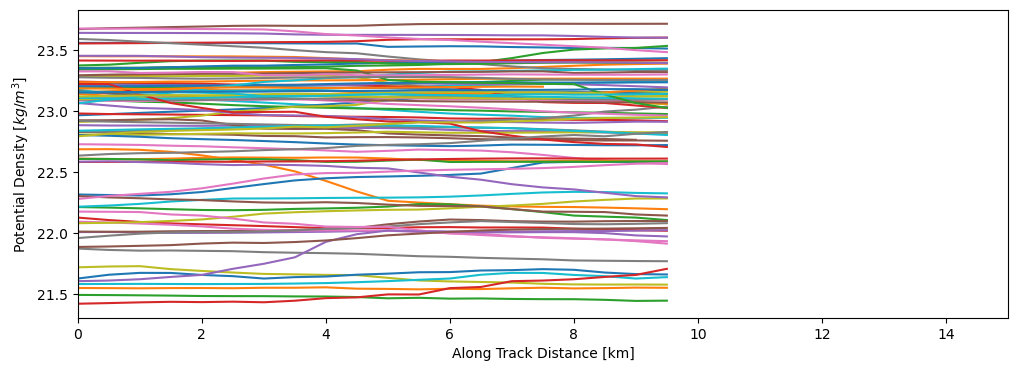

In [36]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(dslist_subset)):
    plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1060').sigma0)
plt.xlim(0,15)
plt.xlabel('Along Track Distance [km]')
plt.ylabel(r'Potential Density $[kg/m^3]$')

Text(0.5, 1.0, '82 Fronts for the 90th - 100th Percentile of Along-Track Density Gradients')

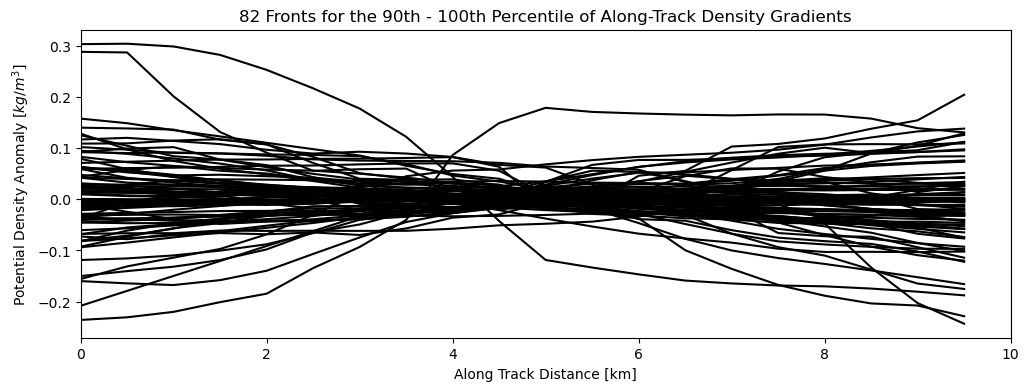

In [37]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(dslist_subset)):
    plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1060').sigma_anom,color='k')
    # plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1061').sigma_anom,color='b')
    # plt.plot(dslist_subset[ds].distance_cum,dslist_subset[ds].sel(saildrone='1026').sigma_anom,color='g')
plt.xlim(0,10)
plt.xlabel('Along Track Distance [km]')
plt.ylabel(r'Potential Density Anomaly $[kg/m^3]$')
plt.title('82 Fronts for the 90th - 100th Percentile of Along-Track Density Gradients')
# plt.ylim(-0.4,0.4)

In [88]:
# for i in range(len(dslist_subset)):
#     dslist_subset[i].to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/90_100_Percentile_Interp05km/ds{}.nc'.format(i))
    

Is there a better way to account for the post-proceessing? Any way I can acheive this in preprocessing?? 

In [112]:
# define time interval and # of data points needed for  least squares
interval = 15
k = 3 

In [113]:
# crop all datasets to 50 m 
for i in range(len(dslist_subset)):
    dslist_subset[i] = dslist_subset[i].isel(depth=slice(0,24))

#### nonadcp gradients 

In [114]:
# calculate coefs for all the front sections 
# calculate density coefficients 
coefs_density = []
for ds in range(len(dslist_subset)):
    coefs_density.append(Coefs_Dataset(subset=dslist_subset[ds],
                         variable='sigma0',
                         var1 = 'rho_mean',
                         var2 = 'rhox',
                         var3 = 'rhoy',
                         interval = interval,
                         k=k,
                         j=False))

In [115]:
# get coefs for b 
# Already ran this so just open saved dataset

coefs_b = []
for ds in range(len(dslist_subset)):
    coefs_b.append(Coefs_Dataset(subset=dslist_subset[ds],
                         variable='b',
                         var1 = 'b_mean',
                         var2 = 'bx',
                         var3 = 'by',
                         interval = interval,
                         k=k,
                         j=False))

In [116]:
# make list of merged coefs (density + buoyancy) 
coefs_nonadcp = []
for ds in range(len(dslist_subset)):
    coefs_nonadcp.append(xr.merge([coefs_density[ds],coefs_b[ds]]))
    # coefs_nonadcp[ds] = coefs_nonadcp[ds].reset_coords()

In [117]:
# concatenate togther - this keeps all times seperate which is what I think I want? 
coefs_nonadcp_merged = xr.concat(coefs_nonadcp,dim='time')

In [118]:
# SAVE THE DATA - MAKE SURE TO CHANGE NAME TO WHAT IS RELEVANT
# coefs_nonadcp_merged.to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/data/frontfinder/coefs_nonadcp_85to90_revised.nc')

#### adcp gradients 

In [119]:
# #Get the coefficients for u and v gradients 
coefs_u_list = []
for ds in range(len(dslist_subset)):
    print([ds])
    coefs_u = []
    for j in range(len(dslist_subset[ds].depth)):
        subset1 = dslist_subset[ds].isel(depth=j)
        coefs_u.append(Coefs_Dataset(subset=subset1,
                         variable='u',
                         var1 = 'u_mean',
                         var2 = 'ux',
                         var3 = 'uy',
                         interval = interval,
                         k = k,
                         j=True))
    coefs_u = xr.merge(coefs_u)
    coefs_u_list.append(coefs_u)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]


In [120]:
# #Get the coefficients for u and v gradients 
coefs_v_list = []
for ds in range(len(dslist_subset)):
    print([ds])
    coefs_v = []
    for j in range(len(dslist_subset[ds].depth)):
        subset1 = dslist_subset[ds].isel(depth=j)
        coefs_v.append(Coefs_Dataset(subset=subset1,
                         variable='v',
                         var1 = 'v_mean',
                         var2 = 'vx',
                         var3 = 'vy',
                         interval = interval,
                         k = k,
                         j=True))
    coefs_v = xr.merge(coefs_v)
    coefs_v_list.append(coefs_v)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]


In [121]:
#Get the coefficients for u and v gradients 
coefs_e_list = []
for ds in range(len(dslist_subset)):
    print([ds])
    coefs_e = []
    for j in range(len(dslist_subset[ds].depth)):
        subset1 = dslist_subset[ds].isel(depth=j)
        coefs_e.append(Coefs_Dataset_Error(subset=subset1,
                         variable='e',
                         var1 = 'e_mean',
                         var2 = 'ex',
                         var3 = 'ey',
                         interval = interval,
                         k = k,
                         j=True))
    coefs_e = xr.merge(coefs_e)
    coefs_e_list.append(coefs_e)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]


In [122]:
# merge coef datasets together for each front 
coefs_adcp = []
for ds in range(len(dslist_subset)):
    coefs_adcp.append(xr.merge([coefs_u_list[ds],coefs_v_list[ds],coefs_e_list[ds]]))

In [124]:
# vertical velocity from divergence 
div_nonnorm = []
w_list = []

for ds in range(len(coefs_adcp)):
    # define a non-normalized divergence to calculate vertical velocity with 
    div_nonnorm = (coefs_adcp[ds].div * gsw.f(coefs_adcp[ds]['latitude']))
    
    # calculate vertical velocity from divergence 
    w = []
    for j in range(len(div_nonnorm.depth)):
        w.append(-np.trapz(div_nonnorm.isel(depth=slice(0,j)),axis=0,dx=2))
    
    coefs_adcp[ds]['w'] = (['depth','time'],w)

In [125]:
# frontogenetic tendency 
# calculate frontogenic tendency 

for ds in range(len(coefs_adcp)):
    coefs_adcp[ds]['F'] = -(coefs_adcp[ds].ux * (coefs_nonadcp[ds].bx)**2 + coefs_adcp[ds].vy * (coefs_nonadcp[ds].by)**2) - (coefs_adcp[ds].vx + coefs_adcp[ds].uy)*coefs_nonadcp[ds].bx*coefs_nonadcp[ds].by


In [126]:
# frontogenetic tendency 
# calculate frontogenic tendency 

for ds in range(len(coefs_adcp)):
    coefs_adcp[ds]['F'] = -(coefs_adcp[ds].ux * (coefs_nonadcp[ds].bx)**2 + coefs_adcp[ds].vy * (coefs_nonadcp[ds].by)**2) - (coefs_adcp[ds].vx + coefs_adcp[ds].uy)*coefs_nonadcp[ds].bx*coefs_nonadcp[ds].by


In [127]:
# FT normalization
    # calculate magnitude of rho gradient and angle (direction)
for ds in range(len(coefs_adcp)):
    rho_mag = np.sqrt(coefs_nonadcp[ds].rhox**2 + coefs_nonadcp[ds].rhoy**2)
    coefs_nonadcp[ds]['rho_mag'] = rho_mag
    
    rho_angle = np.arctan2(coefs_nonadcp[ds].rhoy,coefs_nonadcp[ds].rhox)
    rho_angle = (rho_angle*180)/np.pi
    coefs_nonadcp[ds]['rho_angle'] = rho_angle
    
    f = gsw.f(coefs_adcp[ds]['latitude']).mean()
    g = 9.81
    rho0 = 1025
    gradrho_std = np.std(rho_mag)

    F2 = (g**2/rho0**2) * (gsw.f(coefs_adcp[ds]['latitude'])) * (gradrho_std)**2
    
    coefs_adcp[ds]['F_normalized'] = coefs_adcp[ds]['F'] / F2

In [128]:
# concat all the data together, preserving time dimension for each front 
coefs_adcp_merged = xr.concat(coefs_adcp,dim='time')
# SAVE DATA - MAKE SURE TO CHANGE NAME TO WHAT IS RELEVANT 
# coefs_adcp_merged.to_netcdf('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/data/frontfinder/coefs_adcp_85to90_revised.nc')

In [604]:
for ds in range(len(dslist_subset)):
    # Step 2: calculate rho magnitude and rho angle 
    rho_mag = np.sqrt(coefs_nonadcp[ds].rhox**2 + coefs_nonadcp[ds].rhoy**2)
    rho_angle = np.arctan2(coefs_nonadcp[ds].rhoy,coefs_nonadcp[ds].rhox)    # angle in radians 
    rho_angle = (rho_angle * (180/np.pi))    # angle in degrees 
    
    coefs_nonadcp[ds]['rho_mag'] = rho_mag
    coefs_nonadcp[ds]['rho_angle'] = rho_angle

    front_direction = coefs_nonadcp[ds].rho_angle - 90
    coefs_nonadcp[ds]['front_direction'] = front_direction
    

In [605]:
for ds in range(len(dslist_subset)):
    # calculate magnitude and angle of velocity 
    # calculate rho magnitude and rho angle 
    vel_mag = np.sqrt(coefs_adcp[ds].u_mean**2 + coefs_adcp[ds].v_mean**2)
    vel_angle = np.arctan2(coefs_adcp[ds].v_mean,coefs_adcp[ds].u_mean)    # angle in radians 
    vel_angle = (vel_angle * (180/np.pi))    # angle in degrees 

    coefs_adcp[ds]['vel_mag'] = vel_mag
    coefs_adcp[ds]['vel_angle'] = vel_angle

    # get angle between velocity and front (clockwise???)
    angle = coefs_adcp[ds].vel_angle - coefs_nonadcp[ds].front_direction
    # 360 minus angle to get counter clockwise direction???
    angle = 360-angle

    # get rotated velocity components 
    u_prime, v_prime = rotate_velocity(coefs_adcp[ds].u_mean, coefs_adcp[ds].v_mean, angle*(np.pi/180))
    
    # calculate magnitude of rotated velocity 
    vmag_prime = np.sqrt(u_prime**2 + v_prime**2)

    coefs_adcp[ds]['vel_mag_prime'] = vmag_prime
    coefs_adcp[ds]['u_prime'] = u_prime
    coefs_adcp[ds]['v_prime'] = v_prime

    

In [610]:
for ds in range(len(dslist_subset)):
    # define constants for thermal wind equation 
    f = gsw.f(coefs_adcp[ds]['latitude'])     # coriolis force 
    g = 9.81     # gravity 
    rho0 = 1025    # reference density constant

    # calculate estimated shear from thermal wind equation 
    shear_est = (1/f)*(-g/rho0)*(coefs_nonadcp[ds].rho_mag)
    shear_est = np.absolute(shear_est)

    shear_u = -coefs_adcp[ds].u_prime.differentiate('depth')
    shear_v = -coefs_adcp[ds].v_prime.differentiate('depth')
    shear_obs = np.sqrt(shear_u**2 + shear_v**2)

    coefs_adcp[ds]['shear_est'] = shear_est
    coefs_adcp[ds]['shear_obs'] = shear_obs

    rho_grad_est = f * coefs_adcp[ds].shear_obs * (-rho0/g)
    rho_mag_est = np.absolute(rho_grad_est)

    coefs_adcp[ds]['rho_mag_est'] = rho_mag_est 

In [611]:
coefs_adcp[1]

<xarray.Dataset>
Dimensions:        (time: 20, depth: 24)
Coordinates:
  * time           (time) datetime64[ns] 2020-02-04T08:05:25.663901440 ... 20...
  * depth          (depth) float64 4.24 6.24 8.24 10.24 ... 46.24 48.24 50.24
    longitude      (time) float64 -52.49 -52.49 -52.5 ... -52.56 -52.56 -52.57
    latitude       (time) float64 7.767 7.768 7.768 7.769 ... 7.774 7.774 7.774
Data variables: (12/23)
    u_mean         (depth, time) float64 0.2725 0.2693 0.267 ... 0.3276 0.3297
    ux             (depth, time) float64 9.688e-06 1.052e-05 ... 7.288e-07
    uy             (depth, time) float64 2.564e-05 2.846e-05 ... 1.03e-05
    v_mean         (depth, time) float64 0.09424 0.09573 ... 0.1596 0.1616
    vx             (depth, time) float64 -1.764e-06 -2.532e-06 ... -1.272e-05
    vy             (depth, time) float64 -1.313e-05 -1.832e-05 ... -2.44e-05
    ...             ...
    vel_mag_prime  (depth, time) float64 0.2884 0.2858 0.2838 ... 0.3644 0.3672
    u_prime        (depth, time) float64 0.255 0.2498 0.2345 ... 0.2897 0.2927
    v_prime        (depth, time) float64 0.1346 0.1388 ... -0.2211 -0.2217
    shear_est      (time) float64 0.00228 0.002234 0.00214 ... 0.02519 0.02347
    shear_obs      (depth, time) float64 0.002588 0.003556 ... 0.007399 0.00725
    rho_mag_est    (time, depth) float64 5.329e-06 5.933e-06 ... 1.494e-05

Text(0, 0.5, 'Est Shear')

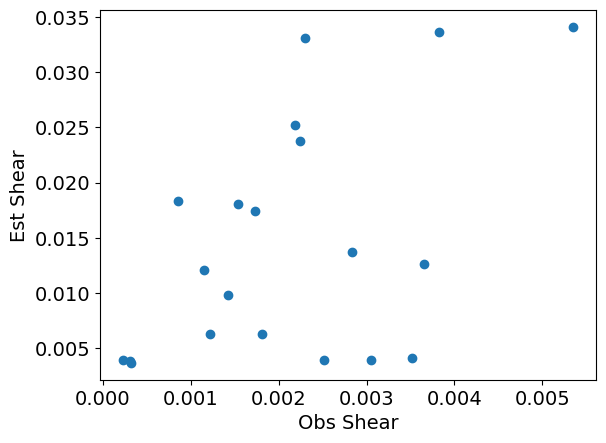

In [612]:
plt.scatter(coefs_adcp[0].shear_obs.isel(depth=0),coefs_adcp[0].shear_est)
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Obs Shear')
plt.ylabel('Est Shear')
# plt.xlim(0,0.04)
# plt.ylim(0,0.04)
# plt.plot([1e-3,4e-2],[1e-3,4e-2],color='k')

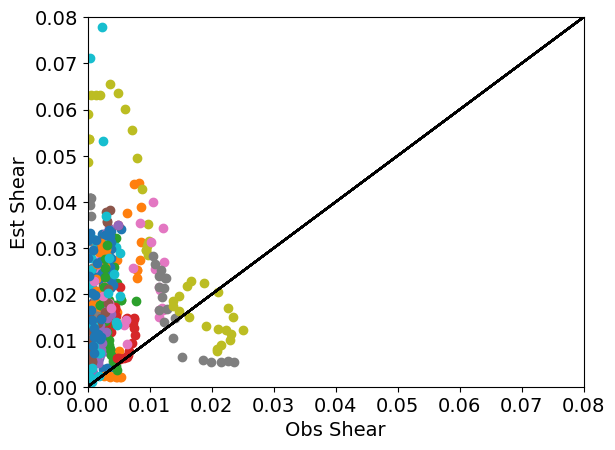

In [614]:

for ds in range(len(dslist_subset)):
    plt.scatter(coefs_adcp[ds].shear_obs.isel(depth=0),coefs_adcp[ds].shear_est)
    # plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
    plt.xlabel('Obs Shear')
    plt.ylabel('Est Shear')
    plt.xlim(0,0.08)
    plt.ylim(0,0.08)
    plt.plot([0,0.08],[0,0.08],color='k')

#### STEP 1: Pick a front from the list of fronts 

In [45]:
import glob

# absolute path to search all text files inside a specific folder
path_fronts = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/*.nc'
path_coefs_nonadcp = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/*.nc'
path_coefs = '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs/*.nc'





In [46]:
filelist_fronts = glob.glob(path_fronts)
filelist_coefs = glob.glob(path_coefs)
filelist_coefs_nonadcp = glob.glob(path_coefs_nonadcp)

In [47]:
filelist_coefs_nonadcp

['/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds2.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds12.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds6.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds16.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds7.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/FrontFinder/99_100_Percentile_Interp05km/coefs_nonadcp/ds17.nc',
 '/Users/mackenzie/Documents/Research/Cesar_Rocha

In [48]:
len(filelist_coefs)

21

In [49]:
# sorts files in order from 1,2,3,4,.... instead of 0,1,10,11,12,...2,20,21,....
from natsort import natsorted 
filelist_fronts = natsorted(filelist_fronts)
filelist_coefs = natsorted(filelist_coefs)
filelist_coefs_nonadcp = natsorted(filelist_coefs_nonadcp)

In [50]:
dslist_subset = []
coefs_adcp = []
coefs_nonadcp = []
for i in range(len(filelist_fronts)):
    dslist_subset.append(xr.open_dataset(filelist_fronts[i]))
    coefs_adcp.append(xr.open_dataset(filelist_coefs[i]))
    coefs_nonadcp.append(xr.open_dataset(filelist_coefs_nonadcp[i]))

                     

In [51]:
# STEP 1: Pick a front from the list of fronts 

adcp = dslist_subset[0]
coefs_adcp_front = coefs_adcp[0]
coefs_nonadcp_front = coefs_nonadcp[0]

#### STEP 2: Visualize the front 

Text(0, 0.5, 'Potential Density')

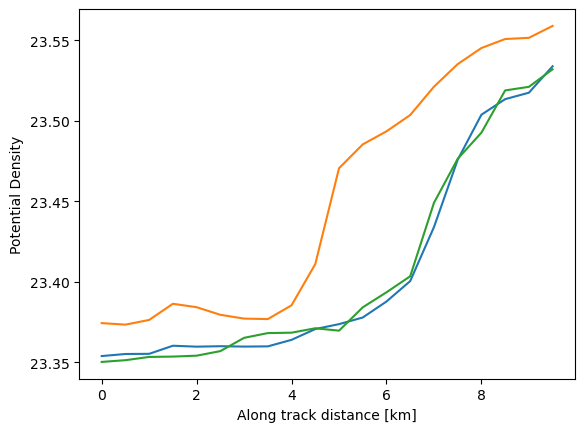

In [52]:
# STEP 2: visualize the front 
plt.plot(adcp.distance_cum,adcp.sel(saildrone='1060').sigma0)
plt.plot(adcp.distance_cum,adcp.sel(saildrone='1061').sigma0)
plt.plot(adcp.distance_cum,adcp.sel(saildrone='1026').sigma0)

plt.xlabel('Along track distance [km]')
plt.ylabel('Potential Density')

<Figure size 1200x400 with 0 Axes>

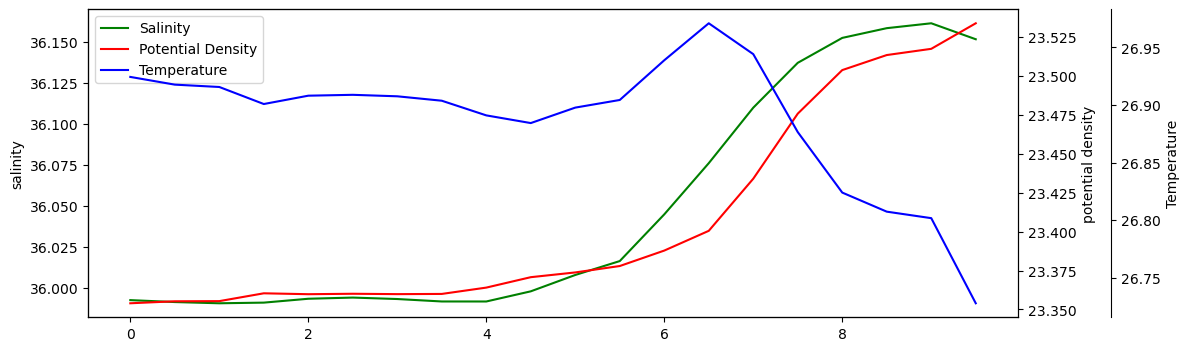

In [53]:
# plot of density through the filament 
# distance vs. salinity 
plt.figure(figsize=(12,4))
fig, ax = plt.subplots(figsize=(12,4))
im0, = ax.plot(adcp.distance_cum,adcp.sel(saildrone='1060').SAL_SBE37_MEAN,color='green',label='Salinity')
twin1 = ax.twinx()
im1, = twin1.plot(adcp.distance_cum,adcp.sel(saildrone='1060').sigma0,color='r',label='Potential Density')

twin2 = ax.twinx()
im2, = twin2.plot(adcp.distance_cum,adcp.sel(saildrone='1060').TEMP_SBE37_MEAN,color='b',label='Temperature')
twin2.spines.right.set_position(("axes", 1.1))


plt.xlabel('Distance [km]')
ax.set_ylabel('salinity')
twin1.set_ylabel('potential density')
twin2.set_ylabel('Temperature')
ax.legend(handles=[im0,im1,im2])

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3617697145.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(adcp.sel(saildrone='1060').distance_cum,
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3617697145.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(label='u velocity [m/s]',pad=0.15)
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3617697145.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimension

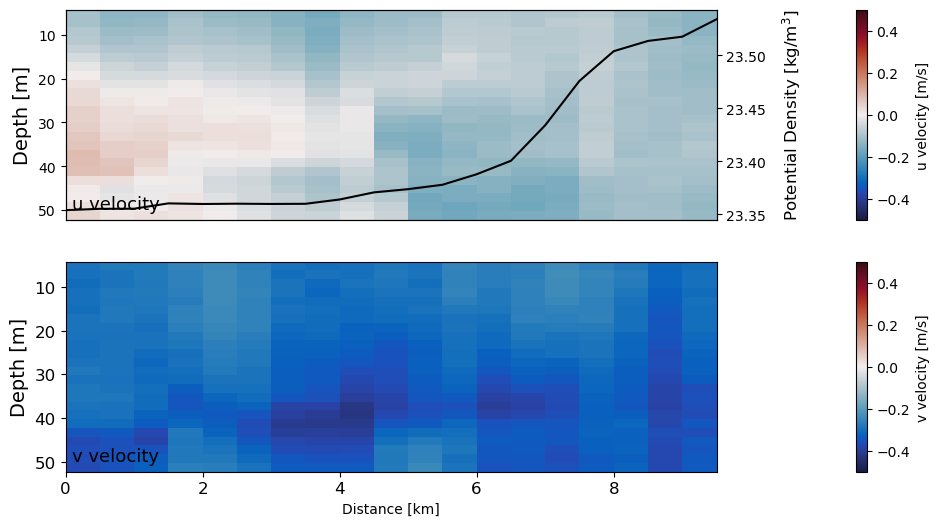

In [54]:
kw = {'cmap': cmocean.cm.balance,
      'vmin':-0.5,
      'vmax':0.5
      }

labelpos = (0.01,0.05)
ylim = (52.24,4.24)

fig = plt.figure(figsize=(12,6))


ax = fig.add_subplot(211)
im = plt.pcolormesh(adcp.sel(saildrone='1060').distance_cum,
               adcp.sel(saildrone='1060').depth,
               adcp.sel(saildrone='1060').u.T,**kw)
plt.ylim(*ylim)
plt.ylabel('Depth [m]',fontsize=14)
ax.text(*labelpos, 'u velocity', fontsize=13,transform=ax.transAxes)
plt.xticks([])

plt.twinx()

plt.plot(adcp.distance_cum,
         adcp.sel(saildrone='1060').sigma0,color='k')
plt.ylabel(r'Potential Density [kg/m$^3$]',fontsize=12,labelpad=10)
plt.colorbar(label='u velocity [m/s]',pad=0.15)

ax = fig.add_subplot(212)
plt.pcolormesh(adcp.sel(saildrone='1060').distance_cum,
               adcp.sel(saildrone='1060').depth,
               adcp.sel(saildrone='1060').v.T,**kw)
plt.ylim(*ylim)
plt.ylabel('Depth [m]',fontsize=14)
plt.xlabel('Distance [km]')

ax.text(*labelpos, 'v velocity', fontsize=13,transform=ax.transAxes)
ax.tick_params(labelsize=12)
plt.colorbar(label='v velocity [m/s]',pad=0.15)

# plt.savefig('/shared/oceandynamics/Data/Atomic/DataMackenzie/FrontCaseStudy1/data/UV_velocity_front1.jpeg',
#             dpi=200,bbox_inches='tight')

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3089601725.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(coefs_adcp_front.time,
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3089601725.py:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(label='Strain',pad=0.1)
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_3104/3089601725.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.

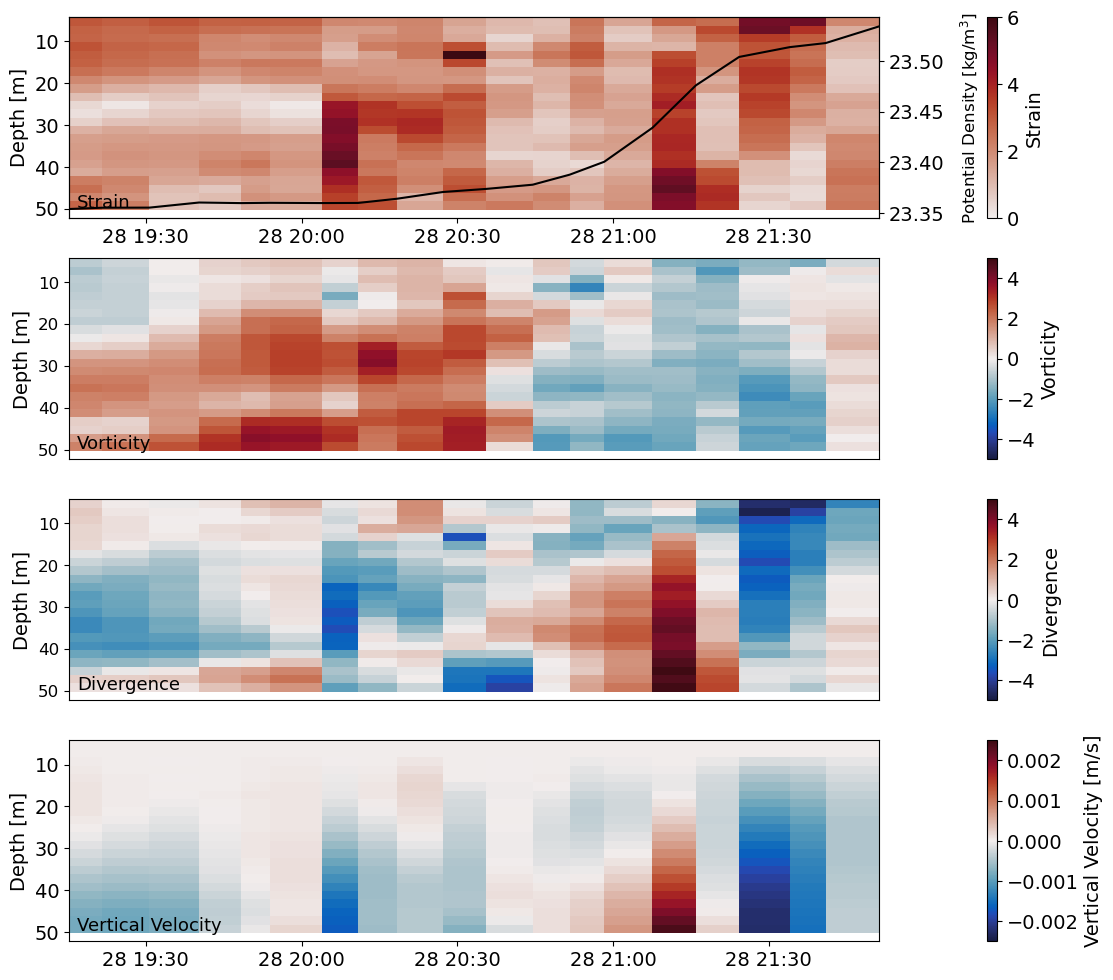

In [55]:
# plot of u and v velocity 

plt.rcParams.update({'font.size': 14})

labelpos = (0.01,0.05)
ylim = (52.24,4.24)

fig = plt.figure(figsize=(16,12))


ax = fig.add_subplot(411)

kw = {'cmap': cmocean.cm.amp,
      'vmin':0,
      'vmax':6
      }
im = plt.pcolormesh(coefs_adcp_front.time,
               coefs_adcp_front.depth,
               coefs_adcp_front.strain,**kw)
plt.ylim(*ylim)
plt.ylabel('Depth [m]',fontsize=14)
ax.text(*labelpos, 'Strain', fontsize=13,transform=ax.transAxes)
plt.xticks([])
# ax.set_yticks([10,20,30,40,50])

plt.twinx()

plt.plot(adcp.time,
         adcp.sel(saildrone='1060').sigma0,color='k')
plt.ylabel(r'Potential Density [kg/m$^3$]',fontsize=12,labelpad=10)
plt.colorbar(label='Strain',pad=0.1)


kw = {'cmap': cmocean.cm.balance,
      'vmin':-5,
      'vmax':5
      }
ax = fig.add_subplot(412)
plt.pcolormesh(coefs_adcp_front.time,
               coefs_adcp_front.depth,
               coefs_adcp_front.vort,**kw)
plt.ylim(*ylim)
plt.xticks([])
plt.ylabel('Depth [m]',fontsize=14)
plt.xticks([])

ax.text(*labelpos, 'Vorticity', fontsize=13,transform=ax.transAxes)
ax.tick_params(labelsize=12)
plt.colorbar(label='Vorticity',pad=0.1)



ax = fig.add_subplot(413)
im = plt.pcolormesh(coefs_adcp_front.time,
                    coefs_adcp_front.depth,
                    coefs_adcp_front.div,**kw)
plt.ylim(*ylim)
plt.ylabel('Depth [m]',fontsize=14)
ax.text(*labelpos, 'Divergence', fontsize=13,transform=ax.transAxes)
ax.tick_params(labelsize=12)
plt.xticks([])
fig.subplots_adjust(right=0.8)
plt.colorbar(label='Divergence',pad=0.1)



# Vertical V
ax = fig.add_subplot(414)

kw = {'cmap': cmocean.cm.balance,
      'vmin':-0.0025,
      'vmax':0.0025
      }

im = plt.pcolormesh(coefs_adcp_front.time,
               coefs_adcp_front.depth,
               coefs_adcp_front.w,**kw)
plt.ylim(*ylim)
plt.ylabel('Depth [m]',fontsize=14)
ax.text(*labelpos, 'Vertical Velocity', fontsize=13,transform=ax.transAxes)
plt.colorbar(label='Vertical Velocity [m/s]',pad=0.1)

# plt.savefig('/shared/oceandynamics/Data/Atomic/DataMackenzie/FrontCaseStudy1/data/Strain_div_vort_w_front1.jpeg',
#             dpi=200,bbox_inches='tight')

#### STEP 3: Calculate rho magnitude and rho angle

In [56]:
# Step 2: calculate rho magnitude and rho angle 
rho_mag = np.sqrt(coefs_nonadcp_front.rhox**2 + coefs_nonadcp_front.rhoy**2)
rho_angle = np.arctan2(coefs_nonadcp_front.rhoy,coefs_nonadcp_front.rhox)    # angle in radians 
rho_angle = (rho_angle * (180/np.pi))    # angle in degrees 

In [57]:
coefs_nonadcp_front['rho_mag'] = rho_mag
coefs_nonadcp_front['rho_angle'] = rho_angle


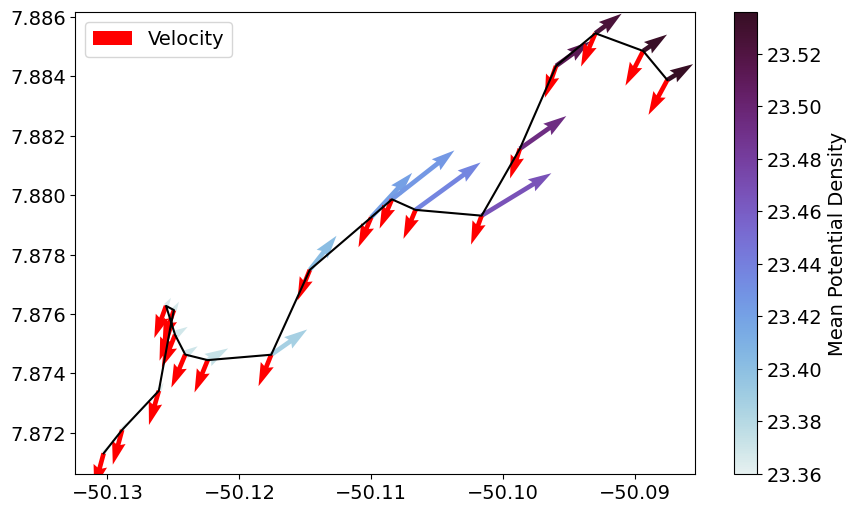

In [58]:

fig = plt.figure(figsize=(10,6))

plt.plot(coefs_nonadcp_front.longitude,coefs_nonadcp_front.latitude,color='k')


im = plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           coefs_nonadcp_front.rhox,
           coefs_nonadcp_front.rhoy,
           coefs_nonadcp_front.rho_mean,
           cmap = cmocean.cm.dense)

# plt.quiver(coefs_nonadcp_front.longitude,
#            coefs_nonadcp_front.latitude,
#            x,
#            y)

plt.quiver(coefs_adcp_front.longitude,
           coefs_adcp_front.latitude,
           coefs_adcp_front.isel(depth=0).u_mean,
           coefs_adcp_front.isel(depth=0).v_mean,color='r',label='Velocity')

plt.legend()


plt.colorbar(im,label='Mean Potential Density')

#### Get front direction by subtracting 90 degrees from rho angle 

In [59]:
front_direction = coefs_nonadcp_front.rho_angle - 90

In [60]:
rho_angle

<xarray.DataArray 'rhoy' (time: 20)>
array([56.99353963, 59.85455714, 58.92653813, 60.70813034, 58.93954096,
       58.71690687, 32.38052347, 33.83263738, 29.78523838, 35.06718034,
       51.94259659, 47.36053801, 38.06707344, 36.0922163 , 31.33180897,
       35.14731972, 35.81704164, 36.65343436, 34.48579411, 31.6063415 ])
Coordinates:
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...

In [61]:
front_direction

<xarray.DataArray 'rho_angle' (time: 20)>
array([-33.00646037, -30.14544286, -31.07346187, -29.29186966,
       -31.06045904, -31.28309313, -57.61947653, -56.16736262,
       -60.21476162, -54.93281966, -38.05740341, -42.63946199,
       -51.93292656, -53.9077837 , -58.66819103, -54.85268028,
       -54.18295836, -53.34656564, -55.51420589, -58.3936585 ])
Coordinates:
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...

In [62]:
# create unit vector for front so we can visualize 
y = np.sin((front_direction * (np.pi/180))) # create y-direction for front 
x = np.cos((front_direction * (np.pi/180))) # create x-direction for front 

In [63]:
front_direction

<xarray.DataArray 'rho_angle' (time: 20)>
array([-33.00646037, -30.14544286, -31.07346187, -29.29186966,
       -31.06045904, -31.28309313, -57.61947653, -56.16736262,
       -60.21476162, -54.93281966, -38.05740341, -42.63946199,
       -51.93292656, -53.9077837 , -58.66819103, -54.85268028,
       -54.18295836, -53.34656564, -55.51420589, -58.3936585 ])
Coordinates:
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...

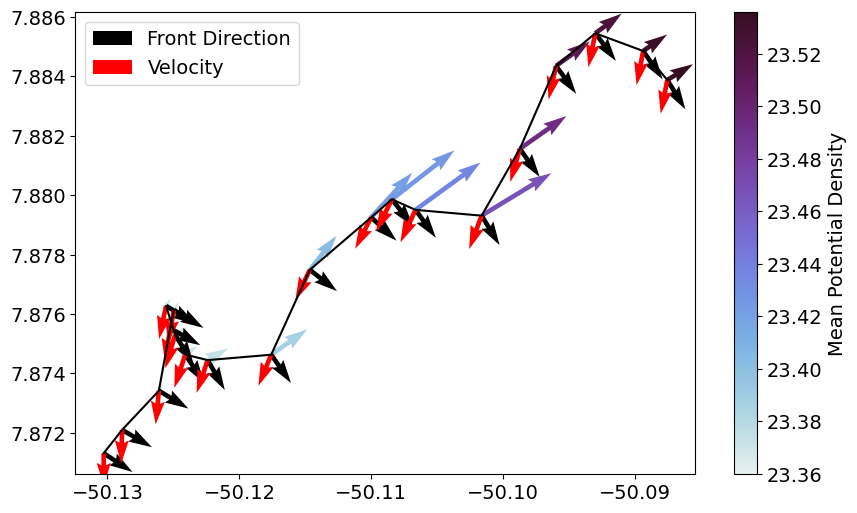

In [64]:
# plt.quiver(coefs_nonadcp.longitude,
#            coefs_nonadcp.latitude,
#            coefs_nonadcp.rhox-90,
#            coefs_nonadcp.rhoy-90,
#            coefs_nonadcp.rho_mean,
#            cmap = cmocean.cm.dense)

fig = plt.figure(figsize=(10,6))

plt.plot(coefs_nonadcp_front.longitude,coefs_nonadcp_front.latitude,color='k')


im = plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           coefs_nonadcp_front.rhox,
           coefs_nonadcp_front.rhoy,
           coefs_nonadcp_front.rho_mean,
           cmap = cmocean.cm.dense)

plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           x,
           y,label='Front Direction')

plt.quiver(coefs_adcp_front.longitude,
           coefs_adcp_front.latitude,
           coefs_adcp_front.isel(depth=20).u_mean,
           coefs_adcp_front.isel(depth=20).v_mean,color='r',label='Velocity')


# plt.quiver(coefs_nonadcp_front.longitude,
#            coefs_nonadcp_front.latitude,
#            u_prime.isel(depth=20),
#            v_prime.isel(depth=20),color='g')


plt.colorbar(im,label='Mean Potential Density')
plt.legend()

#### Rotate velocity vector to be inline with front direction

In [65]:
def rotate_velocity(u,v,angle):
    """Function that rotates velocity component vectors using rotation equations
       
       Inputs: v: u velocity, v velocity, angle: angle between vectors [radians]
       Outputs: rotated v velocity vectors 
    """
    u_prime = u*np.cos(angle) - v*np.sin(angle)
    v_prime = u*np.sin(angle) + v*np.cos(angle)
    
    return u_prime,v_prime

In [66]:
# calculate magnitude and angle of velocity 
# calculate rho magnitude and rho angle 
vel_mag = np.sqrt(coefs_adcp_front.u_mean**2 + coefs_adcp_front.v_mean**2)
vel_angle = np.arctan2(coefs_adcp_front.v_mean,coefs_adcp_front.u_mean)    # angle in radians 
vel_angle = (vel_angle * (180/np.pi))    # angle in degrees 

In [67]:
# get angle between velocity and front (clockwise???)
angle = vel_angle - front_direction
# 360 minus angle to get counter clockwise direction???
angle = 360-angle

In [68]:
# get rotated velocity components 
u_prime, v_prime = rotate_velocity(coefs_adcp_front.u_mean, coefs_adcp_front.v_mean, angle*(np.pi/180))

# calculate magnitude of rotated velocity 
vmag_prime = np.sqrt(u_prime**2 + v_prime**2)



In [69]:
# calculate magnitude of rotated velocity 
vmag_prime = np.sqrt(u_prime**2 + v_prime**2)

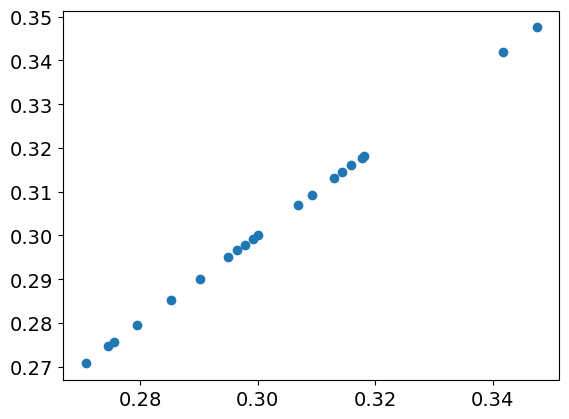

In [70]:
# check that magnitudes are still the same from rotated vs. non rotated velocity 
plt.scatter(vel_mag.isel(depth=0),vmag_prime.isel(depth=0))

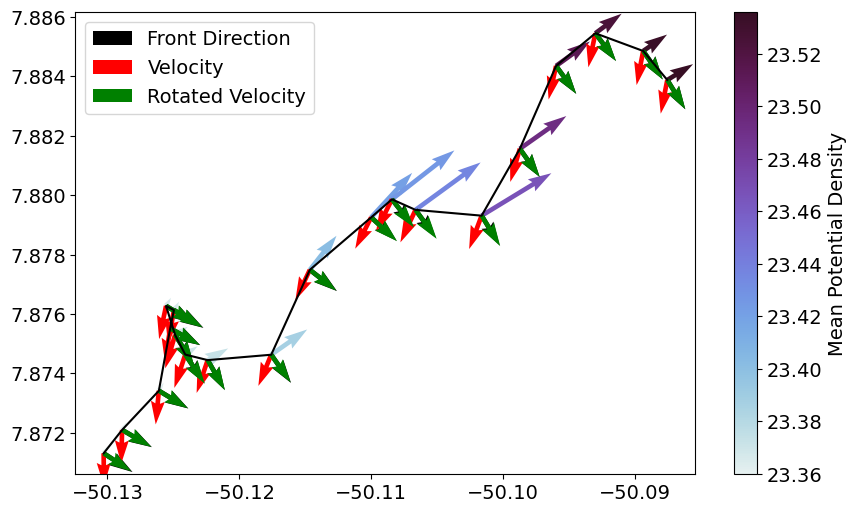

In [71]:
# plt.quiver(coefs_nonadcp.longitude,
#            coefs_nonadcp.latitude,
#            coefs_nonadcp.rhox-90,
#            coefs_nonadcp.rhoy-90,
#            coefs_nonadcp.rho_mean,
#            cmap = cmocean.cm.dense)

fig = plt.figure(figsize=(10,6))

plt.plot(coefs_nonadcp_front.longitude,coefs_nonadcp_front.latitude,color='k')


im = plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           coefs_nonadcp_front.rhox,
           coefs_nonadcp_front.rhoy,
           coefs_nonadcp_front.rho_mean,
           cmap = cmocean.cm.dense)

plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           x,
           y,label='Front Direction')

plt.quiver(coefs_adcp_front.longitude,
           coefs_adcp_front.latitude,
           coefs_adcp_front.isel(depth=20).u_mean,
           coefs_adcp_front.isel(depth=20).v_mean,color='r',label='Velocity')


plt.quiver(coefs_nonadcp_front.longitude,
           coefs_nonadcp_front.latitude,
           u_prime.isel(depth=20),
           v_prime.isel(depth=20),color='g',label='Rotated Velocity')


plt.colorbar(im,label='Mean Potential Density')
plt.legend()

#### Thermal wind equation estimates 

In [574]:
# define constants for thermal wind equation 
f = gsw.f(coefs_adcp_front['latitude'])     # coriolis force 
g = 9.81     # gravity 
rho0 = 1025    # reference density constant 

In [576]:
# calculate estimated shear from thermal wind equation 
shear_est = (1/f)*(-g/rho0)*(rho_mag)

In [578]:
# take magnitude (absolute value) of estimated shear to be comparable with observed 
shear_est = np.absolute(shear_est)

In [579]:
# shear_est = shear_est.expand_dims(dim={'depth':coefs_adcp_front.depth})    #broadcast to all depths?

In [580]:
shear_obs = -vmag_prime.differentiate('depth')

In [581]:
shear_u = -u_prime.differentiate('depth')
shear_v = -v_prime.differentiate('depth')
shear_obs1 = np.sqrt(shear_u**2 + shear_v**2)

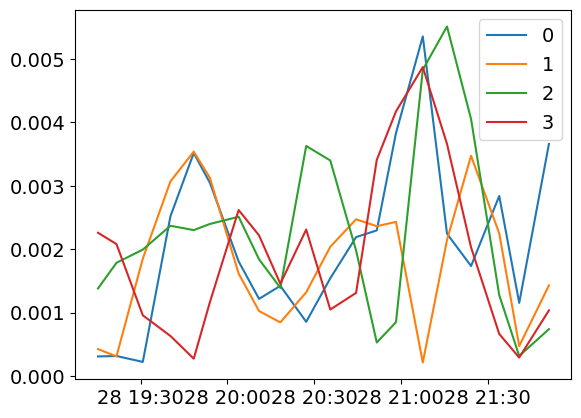

In [582]:
plt.plot(shear_obs1.time,shear_obs1.isel(depth=0),label='0')
plt.plot(shear_obs1.time,shear_obs1.isel(depth=1),label='1')
plt.plot(shear_obs1.time,shear_obs1.isel(depth=2),label='2')
plt.plot(shear_obs1.time,shear_obs1.isel(depth=3),label='3')
# plt.plot(shear_obs1.time,shear_obs1.isel(depth=4),label='4')
# plt.plot(shear_obs1.time,shear_obs1.isel(depth=5),label='5')
# plt.plot(shear_obs1.time,shear_obs1.isel(depth=6),label='6')
# plt.plot(shear_obs1.time,shear_obs1.isel(depth=7),label='7')
plt.legend()

(50.0, 4.24)

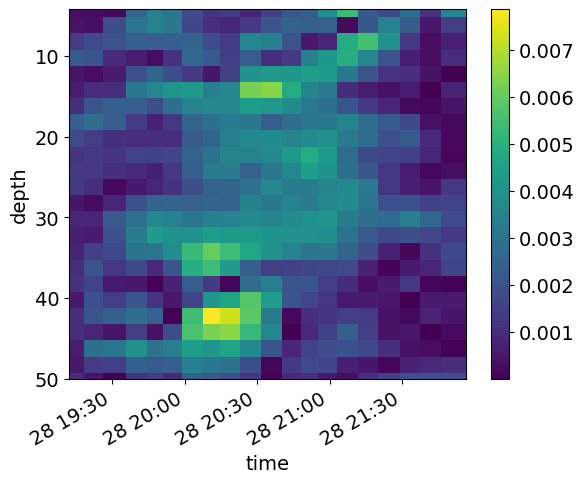

In [583]:
shear_obs1.plot()
plt.ylim(50,4.24)

(0.0, 0.04)

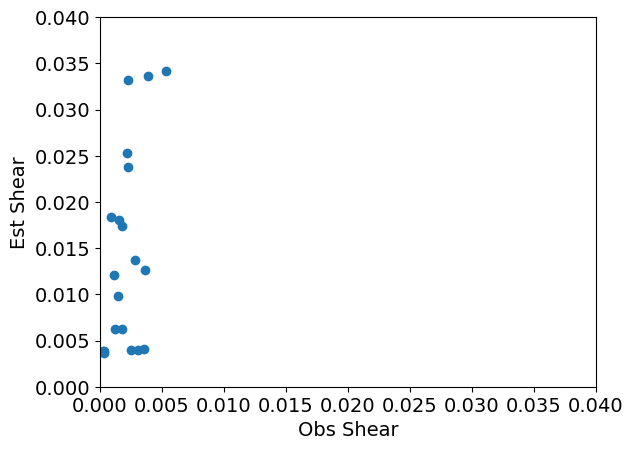

In [589]:
plt.scatter(shear_obs1.isel(depth=0),shear_est)
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Obs Shear')
plt.ylabel('Est Shear')
plt.xlim(0,0.04)
plt.ylim(0,0.04)
# plt.plot([1e-3,4e-2],[1e-3,4e-2],color='k')

#### Estimate lateral density gradient - compare estimted vs. observed 

In [590]:
rho_grad_est = f * shear_obs * (-rho0/g)
rho_mag_est = np.absolute(rho_grad_est)

In [591]:
rho_mag_est = np.absolute(rho_grad_est)

In [592]:
rho_mag_est

<xarray.DataArray (time: 20, depth: 24)>
array([[6.41820949e-07, 8.83580202e-07, 2.87850998e-06, 4.71176856e-06,
        9.43790495e-07, 1.35998474e-06, 2.16904208e-06, 4.96859292e-06,
        3.72532805e-06, 2.56953666e-06, 2.78872040e-06, 2.74423535e-06,
        9.58809430e-07, 1.80126598e-06, 1.45833137e-06, 1.59081652e-06,
        2.08029708e-06, 2.37842338e-06, 1.07134073e-06, 2.15905918e-06,
        2.24294124e-06, 1.31317501e-06, 1.10659928e-06, 2.05424315e-06],
       [6.55875688e-07, 6.44112262e-07, 3.72462323e-06, 4.33955162e-06,
        5.69988889e-07, 2.08051835e-06, 4.18254673e-06, 5.73858999e-06,
        2.92098708e-06, 2.66523733e-06, 2.63017325e-06, 2.16180523e-06,
        5.25514805e-07, 1.64789647e-06, 1.14723868e-06, 3.05793824e-06,
        4.20804541e-06, 3.23302252e-06, 4.01126748e-06, 4.27544737e-06,
        1.72368973e-06, 5.98468134e-06, 2.87001223e-06, 8.91735579e-07],
       [4.62404104e-07, 3.86069760e-06, 4.15817002e-06, 1.99596978e-06,
        1.23362617e-06, 2.18664915e-06, 4.90727429e-06, 4.81457514e-06,
        2.29068578e-06, 2.47932407e-06, 2.24873181e-06, 3.41023318e-07,
        1.62811766e-06, 4.56504066e-06, 4.05246043e-06, 3.63898726e-06,
        2.69810687e-06, 1.12633039e-06, 2.93921703e-06, 4.99881343e-06,
        9.11052755e-07, 6.46528556e-06, 3.01633553e-06, 1.34927000e-07],
       [5.25499545e-06, 6.40498718e-06, 4.94519084e-06, 1.31670984e-06,
        4.01556914e-06, 6.57561582e-06, 4.86036802e-06, 2.86609409e-06,
...
        1.57651767e-07, 1.20278742e-06, 9.98015158e-07, 7.39506706e-07,
        8.25582758e-07, 2.17176874e-06, 2.38840441e-07, 3.21265548e-06],
       [5.93408135e-06, 4.69926548e-06, 2.66377814e-06, 1.38397867e-06,
        2.22474055e-06, 1.34493641e-06, 4.33131128e-07, 3.60252827e-06,
        4.57489272e-06, 3.10269408e-06, 1.32680568e-06, 1.40703823e-06,
        4.11090083e-06, 7.07175084e-06, 3.95822638e-06, 3.16992649e-07,
        1.21217995e-06, 2.59315461e-06, 4.86173822e-08, 4.58314111e-07,
        1.00515052e-06, 7.76424960e-07, 1.49656124e-06, 4.11979817e-06],
       [2.40730367e-06, 9.84409823e-07, 6.59891659e-07, 6.06263554e-07,
        8.14117041e-07, 1.87760320e-08, 2.49155455e-07, 7.31663335e-07,
        1.86918485e-06, 1.66895290e-06, 3.82917483e-07, 9.08469064e-07,
        3.19797428e-06, 5.36278062e-06, 3.45345281e-06, 2.40469762e-06,
        1.67410356e-06, 2.36551049e-07, 1.18528462e-06, 1.60575501e-06,
        1.89233623e-08, 5.54582902e-07, 1.85660383e-06, 3.92230341e-06],
       [7.64488505e-06, 2.98525325e-06, 1.54224834e-06, 2.16057745e-06,
        6.69556205e-08, 1.56479498e-06, 8.73833086e-07, 3.40894448e-07,
        3.39913611e-07, 2.86520064e-07, 5.61263535e-07, 2.59456433e-06,
        3.32320321e-06, 3.70346409e-06, 2.81616080e-06, 3.61185991e-06,
        3.38335020e-06, 8.62799315e-08, 1.18265621e-06, 9.68571707e-07,
        5.09072878e-07, 1.17534104e-07, 2.23030600e-06, 3.89737137e-06]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-28T19:15:12.558177792 ... 2020-0...
    longitude  (time) float64 -50.13 -50.13 -50.13 ... -50.09 -50.09 -50.09
    latitude   (time) float64 7.871 7.872 7.873 7.876 ... 7.885 7.885 7.884
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 44.24 46.24 48.24 50.24

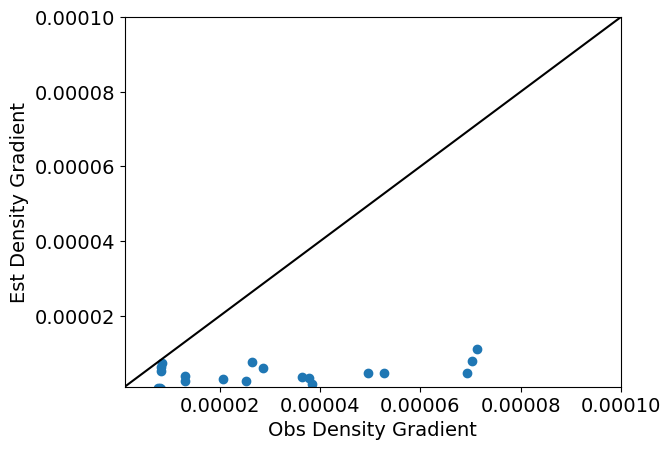

In [593]:
plt.scatter(rho_mag,rho_mag_est.isel(depth=0))
# plt.scatter(shear_est.isel(depth=0),shear_obs1.isel(depth=0))
plt.xlabel('Obs Density Gradient')
plt.ylabel('Est Density Gradient')
plt.xlim(1e-6,1e-4)
plt.ylim(1e-6,1e-4)
plt.plot([1e-6,1e-4],[1e-6,1e-4],color='k')

In [346]:

coefs_adcp_merged.w.mean(), coefs_adcp_merged.w.median(), coefs_adcp_merged.w.std()
stats.skew(coefs_adcp_merged.w.values.flatten(),nan_policy='omit')

(<xarray.DataArray 'vort' ()>
 array(-0.32969109),
 <xarray.DataArray 'vort' ()>
 array(-0.37379167),
 <xarray.DataArray 'vort' ()>
 array(1.27745634))

In [347]:
stats.skew(coefs_adcp_merged.vort.values.flatten(),nan_policy='omit')

0.005220017666810001

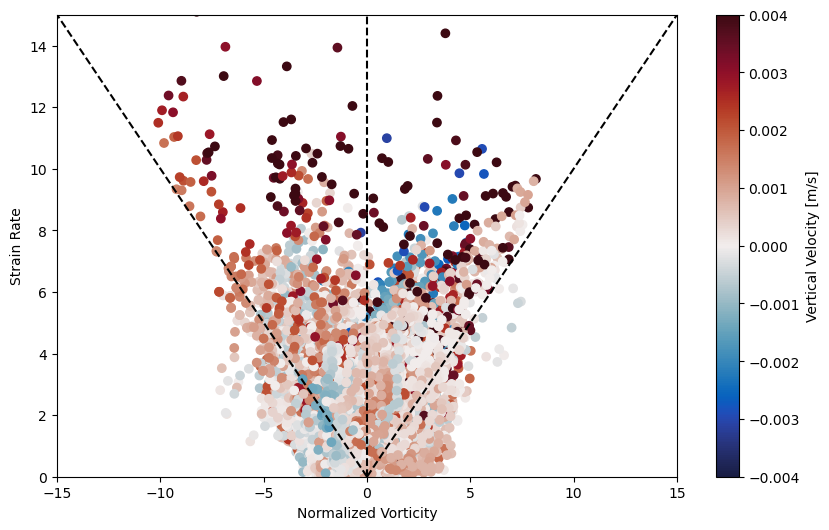

In [348]:
# scatter plot of voriicity vs strain, with vertical velocity colored in the points 
fig = plt.figure(figsize = (10,6))
vmin = -0.004
vmax = 0.004
for ds in range(len(coefs_adcp)):
    # fig = plt.figure(figsize = (10,6))
    x = coefs_adcp[ds].isel(depth=slice(0,24)).vort
    y = coefs_adcp[ds].isel(depth=slice(0,24)).strain
    plt.scatter(x,y,c=coefs_adcp[ds].isel(depth=slice(0,24)).w,cmap=cmocean.cm.balance,vmin=vmin,vmax=vmax)
    plt.xlabel('Normalized Vorticity')
    plt.ylabel('Strain Rate')
    
plt.colorbar(label='Vertical Velocity [m/s]')

xmin = -15
xmax = 15
ymin = 0
ymax = 15
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
# plot 1:1 lines 
plt.plot([0, xmax], [0, xmax], 'k',linestyle='dashed')
plt.plot([0, xmin], [0, -xmin], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
plt.vlines(x=0,ymax=ymax,ymin=ymin,color='k',linestyle='dashed')

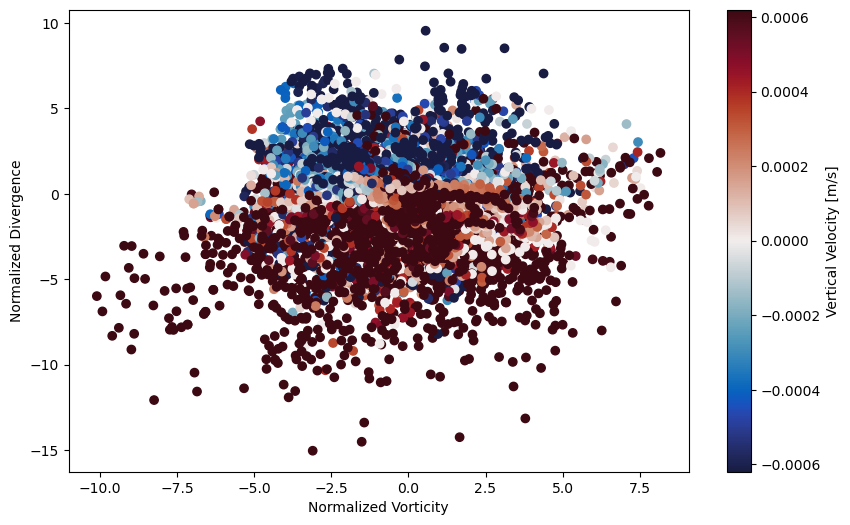

In [349]:
# scatter plot of vorticity and divergence with vertical velocity colored in the points 
fig = plt.figure(figsize = (10,6))
vmin = -0.00062
vmax = 0.00062
for ds in range(len(coefs_adcp)):
    plt.scatter(coefs_adcp[ds].isel(depth=slice(0,24)).vort,coefs_adcp[ds].isel(depth=slice(0,24)).div,
                c = coefs_adcp[ds].isel(depth=slice(0,24)).w,vmin=vmin,vmax=vmax,cmap=cmocean.cm.balance)
plt.xlabel('Normalized Vorticity')
    # plt.xlim(-7,7)
plt.ylabel('Normalized Divergence')
    # plt.ylim(-7,7)
plt.colorbar(label='Vertical Velocity [m/s]')

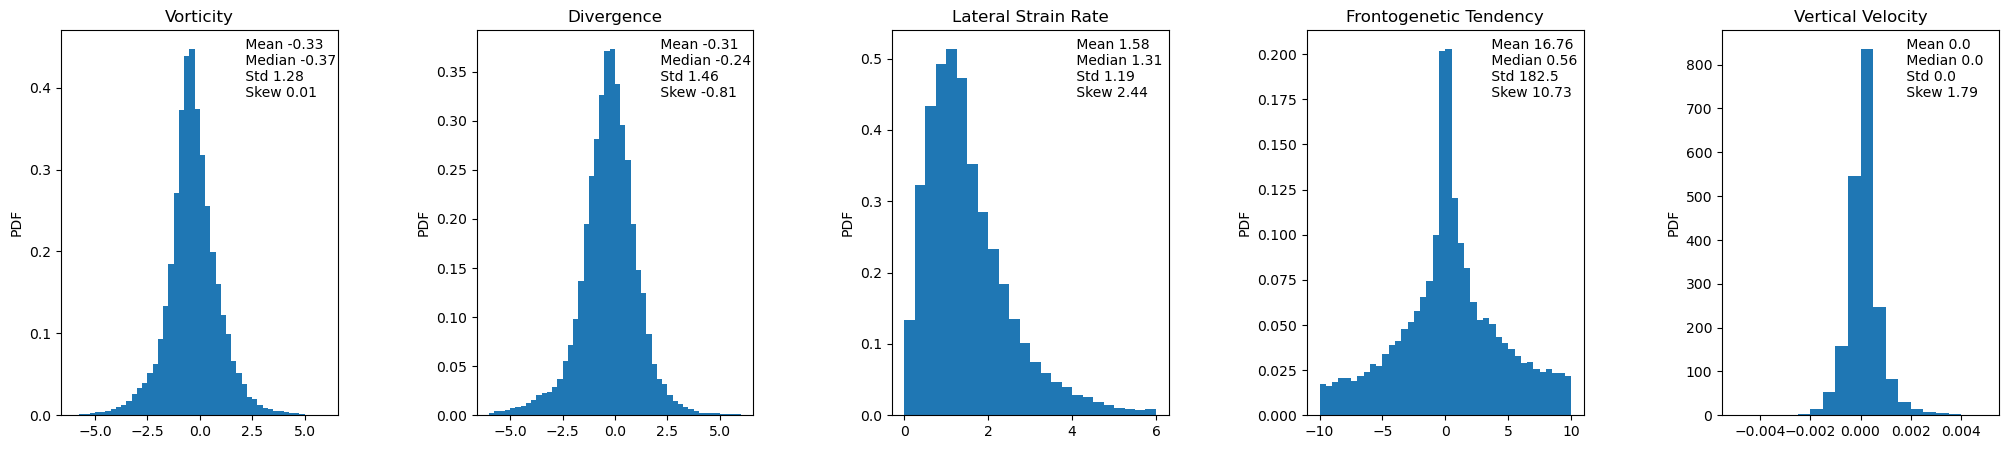

In [350]:
coefs = coefs_adcp_merged.isel(depth=slice(0,24))
dbins, bmin, bmax = 0.25, -6, 6
fig = plt.figure(figsize=(25,5))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
ax2 = fig.add_subplot(153)
ax3 = fig.add_subplot(154)
ax4 = fig.add_subplot(155)


# for ds in range(len(coefs_adcp)):
img0 = ax0.hist(coefs.vort.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.vort.values.flatten())
# std = np.nanstd(coefs.vort.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax0.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# # ax0.legend()


img1 = ax1.hist(coefs.div.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.div.values.flatten())
# std = np.nanstd(coefs.div.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax1.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# # ax1.legend()


img2 = ax2.hist(coefs.strain.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins))

bmin = -10
bmax = 10
dbins = 0.5

img3 = ax3.hist(coefs.F_normalized.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

bmin = -0.005
bmax = 0.005
dbins = 0.0005

img4 = ax4.hist(coefs.w.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))



ax0.set_title('Vorticity')
ax0.set_ylabel('PDF')
ax1.set_title('Divergence')
ax1.set_ylabel('PDF')
ax2.set_title('Lateral Strain Rate')
ax2.set_ylabel('PDF')
ax3.set_title('Frontogenetic Tendency')
ax3.set_ylabel('PDF')
ax4.set_title('Vertical Velocity')
ax4.set_ylabel('PDF')
plt.subplots_adjust(wspace=0.5)

for ax,var in zip([ax0, 
                   ax1, 
                   ax2,
                   ax3,
                   ax4],
                  [coefs.vort.values.flatten(),
                   coefs.div.values.flatten(),
                   coefs.strain.values.flatten(),
                   coefs.F_normalized.values.flatten(),
                   coefs.w.values.flatten()]):
        ax.text(.65,0.9,
                (f' Mean {get_stats(var)[0]} \n Median {get_stats(var)[1]} \n Std {get_stats(var)[2]} \n Skew {get_stats(var)[3]}'.format()),
        ha='left',va='center',transform=ax.transAxes,fontsize=10)

# plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/RD5_Int10_k2.jpeg',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/FullDS_PDFs_upper50m.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

In [351]:
vort_skew = np.ones(len(coefs.depth))
vort_std = np.ones(len(coefs.depth))
for i in range(len(coefs.depth)):
    vort_skew[i] = get_stats(coefs.vort.isel(depth=i).values.flatten())[3]
    vort_std[i] = get_stats(coefs.vort.isel(depth=i).values.flatten())[2]

Text(0.5, 0, 'Vorticity Skewness')

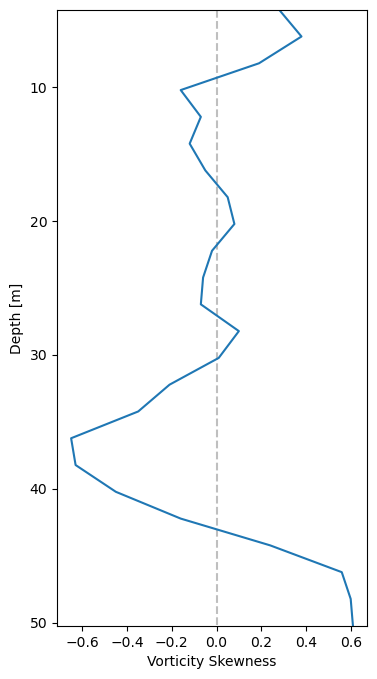

In [352]:
fig = plt.figure(figsize=(4,8))
plt.plot(vort_skew,coefs.depth)
plt.ylim(coefs.depth[-1],coefs.depth[0])
plt.vlines(x=0,ymax=coefs.depth[-1],ymin=coefs.depth[0],linestyle='--',color='grey',alpha=0.5)
plt.ylabel('Depth [m]')
plt.xlabel('Vorticity Skewness')

Text(0.5, 0, 'Vorticity Std')

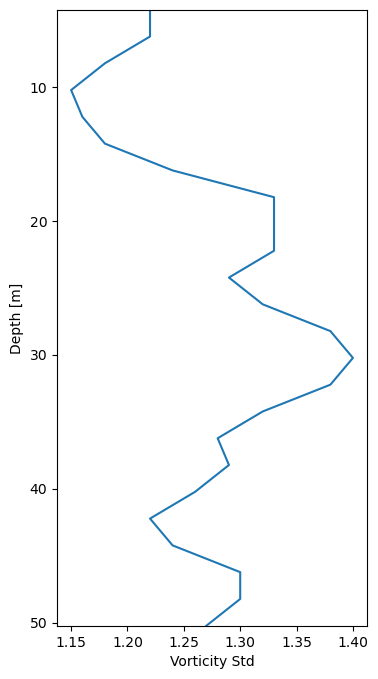

In [353]:
fig = plt.figure(figsize=(4,8))
plt.plot(vort_std,coefs.depth)
plt.ylim(coefs.depth[-1],coefs.depth[0])
# plt.vlines(x=0,ymax=coefs.depth[-1],ymin=coefs.depth[0],linestyle='--',color='grey',alpha=0.5)
plt.ylabel('Depth [m]')
plt.xlabel('Vorticity Std')

Text(0, 0.5, 'Normalized divergence')

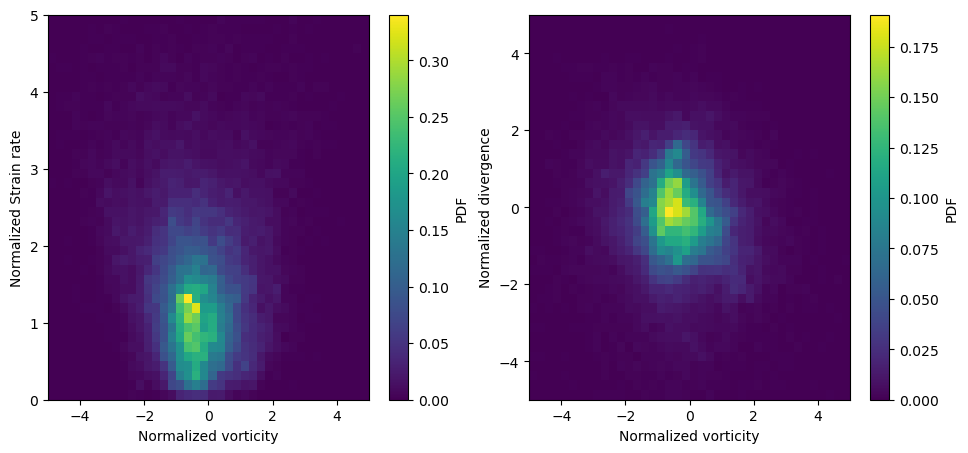

In [354]:
# joint pdfs 
# dbins, bmin, bmax = 0.25, -6, 6
#parameters
dbins, bmin, bmax = 0.25, -5, 5
binsx=np.arange(bmin,bmax+dbins,dbins)
binsy=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)
fig = plt.figure(figsize=(30,5))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
img0 = ax0.hist2d(coefs.vort.values.flatten(),coefs.strain.values.flatten(),density=True,bins=[binsx,bins_s])
ax0.set_xlabel('Normalized vorticity')
ax0.set_ylabel('Normalized Strain rate')
fig.colorbar(img0[3], ax=ax0,label=r'PDF')
img1 = ax1.hist2d(coefs.vort.values.flatten(),coefs.div.values.flatten(),density=True,bins=[binsx,binsy])
plt.colorbar(img1[3],ax=ax1,label=r'PDF')
ax1.set_xlabel('Normalized vorticity')
ax1.set_ylabel('Normalized divergence')

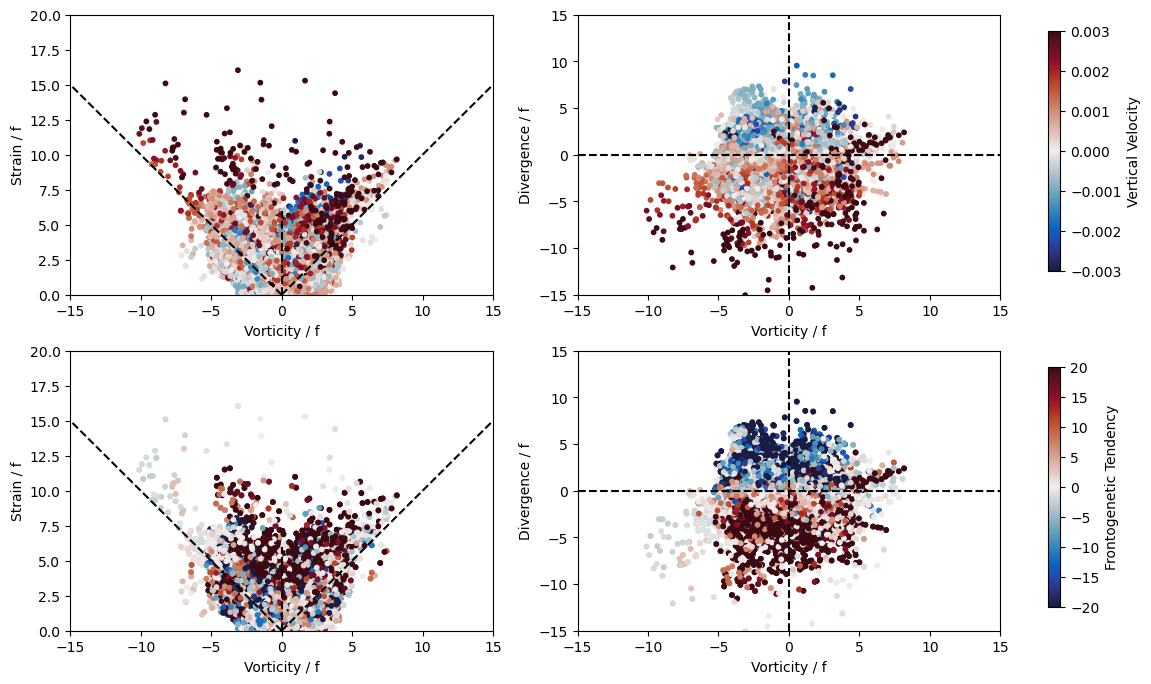

In [355]:
# subplots of:
# 1. strain vs. vorticity colored with vertical velocity 
# 2. divergence vs. vorticity colored with vertical velocity 
# 3. strain vs. vorticity colored with frontogenetic tendency 
# 4. divergence vs. vorticity colored with frontogenetic tendency 

plt.rcParams.update({'font.size': 10})
xmin = -5 
xmax = 5
subset = coefs.isel(depth=slice(0,24))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
max = 15
min = -15

#parameters
kw = {'cmap':cmocean.cm.balance,
      'vmin':-0.003,
      'vmax':0.003}

# first subplot 
ax[0,0].scatter(subset.vort,subset.strain,c=subset.w,s=10,**kw)
ax[0,0].set_xlabel('Vorticity / f')
ax[0,0].set_ylabel('Strain / f')
ax[0,0].set_xlim(min,max)
ax[0,0].set_ylim(0,20)

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[0,0].plot([0, max], [0, max], 'k',linestyle='dashed')
ax[0,0].plot([0, min], [0, -min], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[0,0].vlines(x=0,ymax=6,ymin=0,color='k',linestyle='dashed')

#second subplot
im = ax[0,1].scatter(subset.vort,subset.div,c=subset.w,s=10,**kw)
ax[0,1].set_xlabel('Vorticity / f')
ax[0,1].set_ylabel('Divergence / f')
ax[0,1].set_ylim(min,max)
ax[0,1].set_xlim(min,max)
cbar_ax = fig.add_axes([0.94, 0.56, 0.010, 0.3])
fig.colorbar(im, cax=cbar_ax,label=r'Vertical Velocity')
ax[0,1].plot([min,max],[0,0],'--',color='k')
ax[0,1].plot([0,0],[min,max],'--',color='k')

kw = {'cmap':cmocean.cm.balance,'vmin':-20,'vmax':20}
# third subplot
ax[1,0].scatter(subset.vort,subset.strain,c=subset.F_normalized,s=10,**kw)
ax[1,0].scatter(subset.vort,subset.strain,c=subset.F_normalized,s=10,**kw)
ax[1,0].set_xlabel('Vorticity / f')
ax[1,0].set_ylabel('Strain / f')
ax[1,0].set_xlim(min,max)
ax[1,0].set_ylim(0,20)

# plot 1:1 lines 
x = subset.vort
y = subset.strain
ax[1,0].plot([0, max], [0, max], 'k',linestyle='dashed')
ax[1,0].plot([0, min], [0, -min], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
ax[1,0].vlines(x=0,ymax=6,ymin=0,color='k',linestyle='dashed')

# fourth subplot
im = ax[1,1].scatter(subset.vort,subset.div,c=subset.F_normalized,s=10,**kw)
im = ax[1,1].scatter(subset.vort,subset.div,c=subset.F_normalized,s=10,**kw)
ax[1,1].set_xlabel('Vorticity / f')
ax[1,1].set_ylabel('Divergence / f')
ax[1,1].set_ylim(min,max)
ax[1,1].set_xlim(min,max)
cbar_ax = fig.add_axes([0.94, 0.14, 0.010, 0.3])
fig.colorbar(im, cax=cbar_ax,label=r'Frontogenetic Tendency')
ax[1,1].plot([min,max],[0,0],'--',color='k')
ax[1,1].plot([0,0],[min,max],'--',color='k')

# plt.savefig('/shared/oceandynamics/Data/Atomic/DataMackenzie/FrontCaseStudy1/data/scatterplots_front1.jpeg',
#             dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/FullDS_Scatterplots_upper50m.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

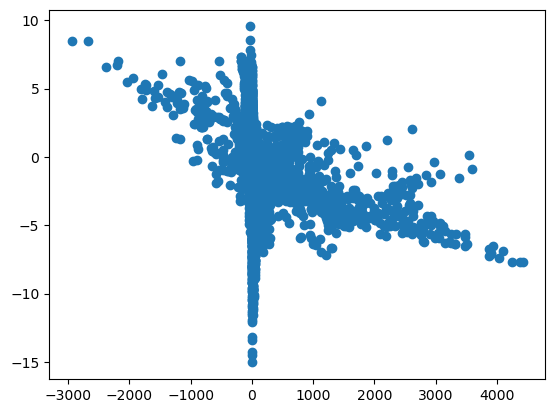

In [356]:
plt.scatter(subset.F_normalized, subset.div)

#### Interpolated dataset - distance as a coordinate that depends on time????

In [14]:
subset = subset.assign_coords(distance = ('time',distance_adcp))
subset_nonadcp = subset_nonadcp.assign_coords(distance = ('time',distance_nonadcp))

In [15]:
subset 

<xarray.Dataset>
Dimensions:    (saildrone: 3, time: 1441, depth: 30)
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00
    latitude   (saildrone, time) float64 ...
    longitude  (saildrone, time) float64 ...
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
    distance   (time) float64 0.0 0.5757 1.182 1.783 ... 589.9 590.4 590.9 591.1
Data variables:
    u          (saildrone, time, depth) float64 ...
    v          (saildrone, time, depth) float64 ...
    w          (saildrone, time, depth) float64 ...
    e          (saildrone, time, depth) float64 ...
    lat        (saildrone, time) float64 ...
    lon        (saildrone, time) float64 ...

In [21]:
# create evenly spaced distance array 
# # dx = 5
# np.arange(0,subset.distance[-1].values)
dist_even = np.linspace(0,subset.distance[-1].values,len(subset.time))

In [22]:
dist_even

array([0.00000000e+00, 4.10496529e-01, 8.20993059e-01, ...,
       5.90294009e+02, 5.90704506e+02, 5.91115002e+02])

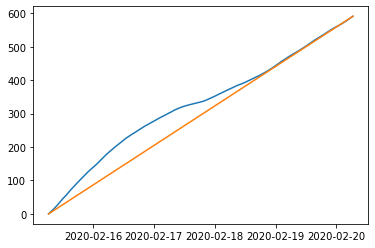

In [23]:
plt.plot(subset.time,subset.distance)
plt.plot(subset.time,dist_even)

#### interpolated dataset - try to keep distance and time 

In [ ]:
subset

<xarray.Dataset>
Dimensions:    (saildrone: 3, time: 1441, depth: 30)
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00
    latitude   (saildrone, time) float64 ...
    longitude  (saildrone, time) float64 ...
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
Data variables:
    u          (saildrone, time, depth) float64 ...
    v          (saildrone, time, depth) float64 ...
    w          (saildrone, time, depth) float64 ...
    e          (saildrone, time, depth) float64 ...
    lat        (saildrone, time) float64 ...
    lon        (saildrone, time) float64 ...

In [ ]:
# create distance variable as new dimension 
subset = subset.expand_dims({'distance':distance_adcp},axis=2)
# create distance variable as new dimension 
subset_nonadcp = subset_nonadcp.expand_dims({'distance':distance_nonadcp},axis=2)

In [ ]:
subset

<xarray.Dataset>
Dimensions:    (distance: 1441, saildrone: 3, time: 1441, depth: 30)
Coordinates:
  * distance   (distance) float64 0.0 0.5757 1.182 1.783 ... 590.4 590.9 591.1
  * saildrone  (saildrone) object '1026' '1060' '1061'
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00
    latitude   (saildrone, time) float64 ...
    longitude  (saildrone, time) float64 ...
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
Data variables:
    u          (saildrone, time, distance, depth) float64 0.101 0.112 ... -0.02
    v          (saildrone, time, distance, depth) float64 -0.211 ... 0.368
    w          (saildrone, time, distance, depth) float64 -0.028 ... 0.008
    e          (saildrone, time, distance, depth) float64 -0.003 0.011 ... 0.005
    lat        (saildrone, time, distance) float64 11.91 11.91 ... 9.483 9.483
    lon        (saildrone, time, distance) float64 -59.06 -59.06 ... -54.86

In [ ]:
# find average distance between points for making evenly spaced distance array 
subset.distance.diff(dim='distance').mean()

<xarray.DataArray 'distance' ()>
array(0.41049653)

In [ ]:
# create evenly spaced distance array 
dx = 5
dist_even = np.arange(0,subset.distance[-1].values,dx)

In [ ]:
dist_even

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355., 360., 365., 370., 375., 380.,
       385., 390., 395., 400., 405., 410., 415., 420., 425., 430., 435.,
       440., 445., 450., 455., 460., 465., 470., 475., 480., 485., 490.,
       495., 500., 505., 510., 515., 520., 525., 530., 535., 540., 545.,
       550., 555., 560., 565., 570., 575., 580., 585., 590.])

In [ ]:
# make into xarray data array 
d = xr.DataArray(dist_even,dims='distance')

In [ ]:
d

<xarray.DataArray (distance: 119)>
array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355., 360., 365., 370., 375., 380.,
       385., 390., 395., 400., 405., 410., 415., 420., 425., 430., 435.,
       440., 445., 450., 455., 460., 465., 470., 475., 480., 485., 490.,
       495., 500., 505., 510., 515., 520., 525., 530., 535., 540., 545.,
       550., 555., 560., 565., 570., 575., 580., 585., 590.])
Dimensions without coordinates: distance

In [ ]:
subset.interp(distance=d)

<xarray.Dataset>
Dimensions:    (saildrone: 3, time: 1441, distance: 119, depth: 30)
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00
    latitude   (saildrone, time) float64 11.91 11.91 11.91 ... 9.483 9.484 9.483
    longitude  (saildrone, time) float64 -59.06 -59.06 -59.05 ... -54.86 -54.86
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
  * distance   (distance) float64 0.0 5.0 10.0 15.0 ... 575.0 580.0 585.0 590.0
Data variables:
    u          (saildrone, time, distance, depth) float64 0.101 0.112 ... -0.02
    v          (saildrone, time, distance, depth) float64 -0.211 ... 0.368
    w          (saildrone, time, distance, depth) float64 -0.028 ... 0.008
    e          (saildrone, time, distance, depth) float64 -0.003 0.011 ... 0.005
    lat        (saildrone, time, distance) float64 11.91 11.91 ... 9.483 9.483
    lon        (saildrone, time, distance) float64 -59.06 -59.06 ... -54.86

In [ ]:
# create time array that matches the size of the new distance array 
t = pd.date_range(start = subset.time[0].values,
              end = subset.time[-1].values,
              periods=len(d))

In [ ]:
t

DatetimeIndex([          '2020-02-15 06:30:00',
               '2020-02-15 07:31:01.016949152',
               '2020-02-15 08:32:02.033898305',
               '2020-02-15 09:33:03.050847457',
               '2020-02-15 10:34:04.067796610',
               '2020-02-15 11:35:05.084745762',
               '2020-02-15 12:36:06.101694915',
               '2020-02-15 13:37:07.118644067',
               '2020-02-15 14:38:08.135593220',
               '2020-02-15 15:39:09.152542372',
               ...
               '2020-02-19 21:20:50.847457627',
               '2020-02-19 22:21:51.864406779',
               '2020-02-19 23:22:52.881355932',
               '2020-02-20 00:23:53.898305084',
               '2020-02-20 01:24:54.915254237',
               '2020-02-20 02:25:55.932203389',
               '2020-02-20 03:26:56.949152542',
               '2020-02-20 04:27:57.966101694',
               '2020-02-20 05:28:58.983050847',
                         '2020-02-20 06:30:00'],
              dtype=

In [ ]:
subset.interp(distance=d)

<xarray.Dataset>
Dimensions:    (saildrone: 3, time: 119, distance: 119, depth: 30)
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
    latitude   (time, saildrone) float64 11.91 11.91 11.9 ... 9.486 9.474 9.483
    longitude  (time, saildrone) float64 -59.06 -59.07 -59.06 ... -54.84 -54.86
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00
  * distance   (distance) float64 0.0 5.0 10.0 15.0 ... 575.0 580.0 585.0 590.0
Data variables:
    u          (time, saildrone, distance, depth) float64 0.101 0.112 ... -0.02
    v          (time, saildrone, distance, depth) float64 -0.211 ... 0.368
    w          (time, saildrone, distance, depth) float64 -0.028 ... 0.008
    e          (time, saildrone, distance, depth) float64 -0.003 0.011 ... 0.005
    lat        (time, saildrone, distance) float64 11.91 11.91 ... 9.483 9.483
    lon        (time, saildrone, distance) float64 -59.06 -59.06 ... -54.86

In [ ]:
# interpolate the dataset with new time and distance 
subset = subset.interp(distance=d,time=t)

In [ ]:
# interpolate the dataset with new time and distance - for nonadcp data 
subset_nonadcp = subset_nonadcp.interp(distance=d,time=t)

In [ ]:
# switch order of dimensions to match nonadcp dataset - good to stay consistent before merging 
subset = subset.transpose('time','saildrone','distance','depth')

In [ ]:
# merge datasets into one 
ds_interp = xr.merge([subset,subset_nonadcp],compat='override')

In [ ]:
ds_interp

<xarray.Dataset>
Dimensions:           (saildrone: 3, time: 119, distance: 119, depth: 30)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
    latitude          (time, saildrone) float64 11.91 11.91 11.9 ... 9.474 9.483
    longitude         (time, saildrone) float64 -59.06 -59.07 ... -54.84 -54.86
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * distance          (distance) float64 0.0 5.0 10.0 15.0 ... 580.0 585.0 590.0
  * time              (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-2...
Data variables:
    u                 (time, saildrone, distance, depth) float64 0.101 ... -0.02
    v                 (time, saildrone, distance, depth) float64 -0.211 ... 0...
    w                 (time, saildrone, distance, depth) float64 -0.028 ... 0...
    e                 (time, saildrone, distance, depth) float64 -0.003 ... 0...
    lat               (time, saildrone, distance) float64 11.91 11.91 ... 9.483
    lon               (time, saildrone, distance) float64 -59.06 ... -54.86
    TEMP_SBE37_MEAN   (time, saildrone, distance) float64 27.08 27.08 ... 27.54
    SAL_SBE37_MEAN    (time, saildrone, distance) float64 35.75 35.75 ... 36.36
    CHLOR_RBR_MEAN    (time, saildrone, distance) float64 3.185 3.185 ... 0.5481
    O2_CONC_RBR_MEAN  (time, saildrone, distance) float64 188.8 188.8 ... 190.7
    b                 (time, saildrone, distance) float64 0.005301 ... 0.008186
    sigma0            (time, saildrone, distance) float64 23.12 23.12 ... 23.42

#### interpolated dataset - replace time with distance

In [10]:
subset['distance'] = ('time',distance_adcp)
subset_nonadcp['distance'] = ('time', distance_nonadcp)

In [11]:
subset = subset.swap_dims({'time':'distance'})
subset_nonadcp = subset_nonadcp.swap_dims({'time':'distance'})

In [12]:
subset['time_int'] = ('distance',pd.to_datetime(subset['time']).astype(np.int64))

In [13]:
subset = subset.reset_coords(names=['latitude','longitude','time'])
subset_nonadcp = subset_nonadcp.reset_coords(names=['latitude','longitude','time'])

In [14]:
subset

<xarray.Dataset>
Dimensions:    (saildrone: 3, distance: 1441, depth: 30)
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
  * depth      (depth) float64 4.24 6.24 8.24 10.24 ... 56.24 58.24 60.24 62.24
  * distance   (distance) float64 0.0 0.5757 1.182 1.783 ... 590.4 590.9 591.1
Data variables:
    time       (distance) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T0...
    u          (saildrone, distance, depth) float64 ...
    v          (saildrone, distance, depth) float64 ...
    w          (saildrone, distance, depth) float64 ...
    e          (saildrone, distance, depth) float64 ...
    latitude   (saildrone, distance) float64 ...
    longitude  (saildrone, distance) float64 ...
    time_int   (distance) int64 1581748200000000000 ... 1582180200000000000

In [15]:
# create evenly spaced distance array 
dx = 0.5
dist_even = np.arange(0,subset.distance[-1].values,dx)

In [16]:
# make into xarray data array 
d = xr.DataArray(dist_even,dims='distance')

In [17]:
d

<xarray.DataArray (distance: 1183)>
array([0.000e+00, 5.000e-01, 1.000e+00, ..., 5.900e+02, 5.905e+02,
       5.910e+02])
Dimensions without coordinates: distance

In [18]:
# interpolate the dataset with new time and distance 
subset_interp = subset.interp(distance=d)
subset_nonadcp_interp = subset_nonadcp.interp(distance=d)

In [19]:
# switch order of dimensions to match nonadcp dataset - good to stay consistent before merging 
subset_interp = subset_interp.transpose('distance','saildrone','depth')

In [20]:
ds_interp = xr.merge([subset_interp,subset_nonadcp_interp],compat='override')

In [21]:
ds_interp['time'] = ('distance',pd.to_datetime(ds_interp['time_int'].values))

In [32]:
ds_interp

<xarray.Dataset>
Dimensions:           (saildrone: 3, distance: 1183, depth: 30)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * distance          (distance) float64 0.0 0.5 1.0 1.5 ... 590.0 590.5 591.0
Data variables: (12/16)
    u                 (distance, saildrone, depth) float64 0.101 ... -0.0287
    v                 (distance, saildrone, depth) float64 -0.211 ... 0.3748
    w                 (distance, saildrone, depth) float64 -0.028 ... 0.004617
    e                 (distance, saildrone, depth) float64 -0.003 ... 0.008383
    latitude          (distance, saildrone) float64 11.91 11.91 ... 9.475 9.484
    longitude         (distance, saildrone) float64 -59.06 -59.07 ... -54.86
    ...                ...
    SAL_SBE37_MEAN    (distance, saildrone) float64 35.75 35.76 ... 36.35 36.35
    CHLOR_RBR_MEAN    (distance, saildrone) float64 3.185 0.7791 ... 0.5514
    O2_CONC_RBR_MEAN  (distance, saildrone) float64 188.8 192.0 ... 189.5 190.8
    b                 (distance, saildrone) float64 0.005301 ... 0.008119
    sigma0            (distance, saildrone) float64 23.12 23.14 ... 23.41 23.42
    time              (distance) datetime64[ns] 2020-02-15T06:30:00 ... 2020-...

In [34]:
ds_interp = ds_interp.swap_dims({'distance':'time'})

In [24]:
ds_interp = ds_interp.swap_dims({'distance':'time'})

In [25]:
ds_interp

<xarray.Dataset>
Dimensions:           (saildrone: 3, time: 1183, depth: 30)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
    distance          (time) float64 0.0 0.5 1.0 1.5 ... 589.5 590.0 590.5 591.0
  * time              (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-2...
Data variables: (12/13)
    u                 (time, saildrone, depth) float64 0.101 0.112 ... -0.0287
    v                 (time, saildrone, depth) float64 -0.211 -0.209 ... 0.3748
    w                 (time, saildrone, depth) float64 -0.028 ... 0.004617
    e                 (time, saildrone, depth) float64 -0.003 0.011 ... 0.008383
    latitude          (time, saildrone) float64 11.91 11.91 11.9 ... 9.475 9.484
    longitude         (time, saildrone) float64 -59.06 -59.07 ... -54.84 -54.86
    ...                ...
    TEMP_SBE37_MEAN   (time, saildrone) float64 27.08 27.07 ... 27.55 27.55
    SAL_SBE37_MEAN    (time, saildrone) float64 35.75 35.76 ... 36.35 36.35
    CHLOR_RBR_MEAN    (time, saildrone) float64 3.185 0.7791 ... 0.5361 0.5514
    O2_CONC_RBR_MEAN  (time, saildrone) float64 188.8 192.0 ... 189.5 190.8
    b                 (time, saildrone) float64 0.005301 0.00543 ... 0.008119
    sigma0            (time, saildrone) float64 23.12 23.14 ... 23.41 23.42

#### Calculate rho diff

In [26]:
# calculate rho difference along time 
rho_diff = ds_interp.sigma0.diff(dim='time')

In [27]:
rho_diff

<xarray.DataArray 'sigma0' (time: 1182, saildrone: 3)>
array([[ 0.00029725,  0.00011214,  0.00155409],
       [ 0.00094326,  0.00129729,  0.00129247],
       [ 0.00100916,  0.00123583,  0.00102205],
       ...,
       [-0.00361749, -0.00348192, -0.0016522 ],
       [ 0.00071503,  0.0016287 , -0.00062029],
       [ 0.0005152 ,  0.00189552,  0.00151941]])
Coordinates:
  * saildrone  (saildrone) object '1026' '1060' '1061'
    distance   (time) float64 0.5 1.0 1.5 2.0 2.5 ... 589.5 590.0 590.5 591.0
  * time       (time) datetime64[ns] 2020-02-15T06:34:20.529952 ... 2020-02-2...

In [28]:
# add variable to dataset 
ds_interp['rho_diff'] = rho_diff

In [29]:
# reset coords to get distance as variable
ds_interp = ds_interp.reset_coords()

In [38]:
# apply resample to get desired horizontal resolution for fronts - try 5 km to start 
# resample by time??? or coarsen by distance??? 

# do I even need to resample since I create the interpolated dataset above based on an arbitrarily picked evenly spaced distance??
# i.e. resampling to a desired horizontal res can be done in the interpolation??? 

h_res = 5 
ds_interp.resample(time='8MIN').mean()

<xarray.Dataset>
Dimensions:           (saildrone: 3, depth: 30, time: 901)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * time              (time) datetime64[ns] 2020-02-15T06:24:00 ... 2020-02-2...
Data variables: (12/15)
    u                 (time, saildrone, depth) float64 0.101 0.112 ... -0.0287
    v                 (time, saildrone, depth) float64 -0.211 -0.209 ... 0.3748
    w                 (time, saildrone, depth) float64 -0.028 ... 0.004617
    e                 (time, saildrone, depth) float64 -0.003 0.011 ... 0.008383
    latitude          (time, saildrone) float64 11.91 11.91 11.9 ... 9.475 9.484
    longitude         (time, saildrone) float64 -59.06 -59.07 ... -54.84 -54.86
    ...                ...
    SAL_SBE37_MEAN    (time, saildrone) float64 35.75 35.76 ... 36.35 36.35
    CHLOR_RBR_MEAN    (time, saildrone) float64 3.185 0.7791 ... 0.5361 0.5514
    O2_CONC_RBR_MEAN  (time, saildrone) float64 188.8 192.0 ... 189.5 190.8
    b                 (time, saildrone) float64 0.005301 0.00543 ... 0.008119
    sigma0            (time, saildrone) float64 23.12 23.14 ... 23.41 23.42
    rho_diff          (time, saildrone) float64 nan nan ... 0.001896 0.001519

In [41]:
# define gradient threshold 
gradient_threshold_max = 0.01
gradient_threshold_min = -0.01

In [63]:
ds_interp = ds_interp.set_coords('distance')

In [66]:
# how can I apply where statement to multiple dimensions? 
ds_interp_max = ds_interp.where(ds_interp.rho_diff >= gradient_threshold_max,drop=True)

In [67]:
ds_interp_max

<xarray.Dataset>
Dimensions:           (time: 147, saildrone: 3, depth: 30)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * time              (time) datetime64[ns] 2020-02-15T09:11:04.284169984 ......
    distance          (time) float64 19.5 33.5 235.5 314.0 ... 544.0 544.5 545.0
Data variables: (12/14)
    u                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    v                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    w                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    e                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    latitude          (time, saildrone) float64 nan nan 11.79 ... 9.553 nan nan
    longitude         (time, saildrone) float64 nan nan -58.95 ... nan nan
    ...                ...
    SAL_SBE37_MEAN    (time, saildrone) float64 nan nan 35.84 ... 36.21 nan nan
    CHLOR_RBR_MEAN    (time, saildrone) float64 nan nan 0.6462 ... nan nan
    O2_CONC_RBR_MEAN  (time, saildrone) float64 nan nan 193.1 ... 187.1 nan nan
    b                 (time, saildrone) float64 nan nan 0.006093 ... nan nan
    sigma0            (time, saildrone) float64 nan nan 23.21 ... 23.4 nan nan
    rho_diff          (time, saildrone) float64 nan nan 0.01195 ... nan nan

In [68]:
ds_interp_min = ds_interp.where(ds_interp.rho_diff <= gradient_threshold_min,drop=True)

In [69]:
ds_interp_min

<xarray.Dataset>
Dimensions:           (time: 134, saildrone: 3, depth: 30)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * time              (time) datetime64[ns] 2020-02-16T13:31:37.488638464 ......
    distance          (time) float64 229.0 229.5 230.0 ... 525.5 529.0 549.0
Data variables: (12/14)
    u                 (time, saildrone, depth) float64 -0.1247 -0.1247 ... nan
    v                 (time, saildrone, depth) float64 -0.3168 -0.3138 ... nan
    w                 (time, saildrone, depth) float64 -0.0276 -0.02995 ... nan
    e                 (time, saildrone, depth) float64 -0.0084 ... nan
    latitude          (time, saildrone) float64 10.41 nan nan ... 9.546 nan nan
    longitude         (time, saildrone) float64 -57.63 nan nan ... nan nan
    ...                ...
    SAL_SBE37_MEAN    (time, saildrone) float64 36.05 nan nan ... 36.24 nan nan
    CHLOR_RBR_MEAN    (time, saildrone) float64 0.3861 nan nan ... nan nan
    O2_CONC_RBR_MEAN  (time, saildrone) float64 187.8 nan nan ... 186.9 nan nan
    b                 (time, saildrone) float64 0.007236 nan nan ... nan nan
    sigma0            (time, saildrone) float64 23.32 nan nan ... 23.38 nan nan
    rho_diff          (time, saildrone) float64 -0.01383 nan nan ... nan nan

In [70]:
ds_combined = xr.merge([ds_interp_min,ds_interp_max])

In [71]:
ds_combined

<xarray.Dataset>
Dimensions:           (saildrone: 3, depth: 30, time: 276)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
  * time              (time) datetime64[ns] 2020-02-15T09:11:04.284169984 ......
    distance          (time) float64 19.5 33.5 229.0 229.5 ... 544.5 545.0 549.0
Data variables: (12/14)
    u                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    v                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    w                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    e                 (time, saildrone, depth) float64 nan nan nan ... nan nan
    latitude          (time, saildrone) float64 nan nan 11.79 ... 9.546 nan nan
    longitude         (time, saildrone) float64 nan nan -58.95 ... nan nan
    ...                ...
    SAL_SBE37_MEAN    (time, saildrone) float64 nan nan 35.84 ... 36.24 nan nan
    CHLOR_RBR_MEAN    (time, saildrone) float64 nan nan 0.6462 ... nan nan
    O2_CONC_RBR_MEAN  (time, saildrone) float64 nan nan 193.1 ... 186.9 nan nan
    b                 (time, saildrone) float64 nan nan 0.006093 ... nan nan
    sigma0            (time, saildrone) float64 nan nan 23.21 ... 23.38 nan nan
    rho_diff          (time, saildrone) float64 nan nan 0.01195 ... nan nan

#### Select points in dataset centered around strong density gradient (to get S shape for front)

In [101]:
np.arange(ds_combined.distance[0].values-(dx*10),ds_combined.distance[0].values+(dx*10)+dx,dx)

array([14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5,
       20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5])

In [102]:
dx

0.5

In [105]:
array_list = []
for i in range(len(ds_combined.distance)):
    array_list.append(np.arange(ds_combined.distance[i].values-(dx*10),ds_combined.distance[i].values+(dx*10)+dx,dx))

In [106]:
array_list[0]

array([14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5,
       20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5])

In [99]:
ds_interp = ds_interp.swap_dims({'time':'distance'})

In [108]:
ds_list = []
for i in range(len(array_list)):
    ds_list.append(ds_interp.sel(distance=array_list[i]))

In [110]:
ds_list[20]

<xarray.Dataset>
Dimensions:           (saildrone: 3, depth: 30, distance: 21)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * depth             (depth) float64 4.24 6.24 8.24 10.24 ... 58.24 60.24 62.24
    time              (distance) datetime64[ns] 2020-02-16T14:27:59.472523008...
  * distance          (distance) float64 233.5 234.0 234.5 ... 242.5 243.0 243.5
Data variables: (12/14)
    u                 (distance, saildrone, depth) float64 -0.1981 ... -0.1732
    v                 (distance, saildrone, depth) float64 0.1394 ... -0.291
    w                 (distance, saildrone, depth) float64 -0.0174 ... 0.01094
    e                 (distance, saildrone, depth) float64 -0.001179 ... 0.00...
    latitude          (distance, saildrone) float64 10.38 10.38 ... 10.31 10.3
    longitude         (distance, saildrone) float64 -57.6 -57.61 ... -57.54
    ...                ...
    SAL_SBE37_MEAN    (distance, saildrone) float64 35.58 35.63 ... 34.95 34.95
    CHLOR_RBR_MEAN    (distance, saildrone) float64 0.3563 0.3032 ... 0.3525
    O2_CONC_RBR_MEAN  (distance, saildrone) float64 189.1 192.6 ... 194.0 195.1
    b                 (distance, saildrone) float64 0.004596 ... 0.0002516
    sigma0            (distance, saildrone) float64 23.05 23.09 ... 22.59 22.6
    rho_diff          (distance, saildrone) float64 -0.1105 ... -0.01011

In [10]:
# calculate density difference and add zero at beginning of array 
empty_list = []
for i in [0,1,2]:
    empty_list.append(np.hstack([0,subset_nonadcp.sigma0.diff(dim='time')[i]]))

In [11]:
# convert to xarray dataarray 
density_diff = xr.DataArray(empty_list,
             dims={'saildrone':subset_nonadcp.saildrone,'time':subset_nonadcp.time})

In [12]:
# add to dataset as a new variable 
subset_nonadcp['rho_diff'] = density_diff

In [13]:
subset_nonadcp

<xarray.Dataset>
Dimensions:           (saildrone: 3, time: 7201)
Coordinates:
    latitude          (saildrone, time) float64 ...
    longitude         (saildrone, time) float64 ...
  * time              (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-2...
  * saildrone         (saildrone) object '1026' '1060' '1061'
Data variables:
    TEMP_SBE37_MEAN   (saildrone, time) float64 ...
    SAL_SBE37_MEAN    (saildrone, time) float64 ...
    CHLOR_RBR_MEAN    (saildrone, time) float64 ...
    O2_CONC_RBR_MEAN  (saildrone, time) float64 ...
    b                 (saildrone, time) float64 ...
    sigma0            (saildrone, time) float64 ...
    distance          (time) float64 ...
    lat               (saildrone, time) float64 ...
    lon               (saildrone, time) float64 ...
    rho_diff          (saildrone, time) float64 0.0 -0.0003162 ... 0.0001006

In [18]:
subset_nonadcp.rho_diff.max()

<xarray.DataArray 'rho_diff' ()>
array(0.13756264)

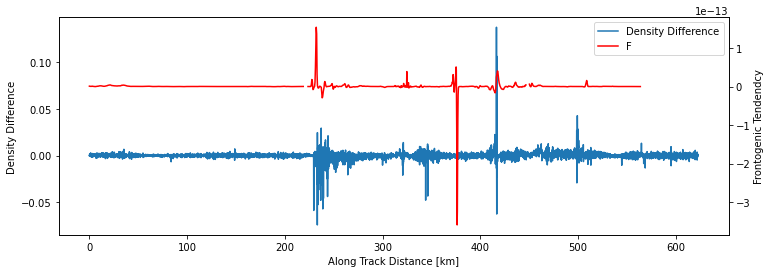

In [21]:
# plot of density gradient and frontogenic tendency 
fig, ax = plt.subplots(figsize=(12,4))

im0, = ax.plot(subset_nonadcp.distance,subset_nonadcp.sel(saildrone='1060').rho_diff,label='Density Difference')
twinx = ax.twinx()
im1, = twinx.plot(allcoefs.distance,allcoefs.isel(depth=0).F,color='r',label = 'F')
ax.set_ylabel('Density Difference')
twinx.set_ylabel('Frontogenic Tendendcy')
ax.set_xlabel("Along Track Distance [km]")
plt.legend(handles=[im0,im1])

In [29]:
# define a sampling interval and find what average distance between points that corresponds to 
resampling_interval = '5MIN'
sw.dist(lat=subset.sel(saildrone='1060').resample(time=resampling_interval).mean(dim='time').lat, 
        lon = subset.sel(saildrone='1060').resample(time=resampling_interval).mean(dim='time').lon,units='km')[0].mean()

0.41049652943585263

In [30]:
# resample datasets to resampling interval 
subset_nonadcp_resampled = subset_nonadcp.resample(time=resampling_interval).mean(dim='time')
coefs_nonadcp_resampled = coefs_nonadcp.resample(time=resampling_interval).mean(dim='time')
subset_resampled = subset.resample(time=resampling_interval).mean(dim='time')
allcoefs_resampled = allcoefs.resample(time=resampling_interval).mean(dim='time')


In [53]:
# define gradient threshold 
gradient_threshold_max = 0.01
gradient_threshold_min = -0.01

In [110]:
subset_nonadcp_resampled.where(subset_nonadcp_resampled.rho_diff >= gradient_threshold_max,drop=True)

<xarray.Dataset>
Dimensions:           (time: 9, saildrone: 3)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * time              (time) datetime64[ns] 2020-02-18T12:15:00 ... 2020-02-1...
Data variables:
    TEMP_SBE37_MEAN   (time, saildrone) float64 nan 26.95 nan ... nan 27.31 nan
    SAL_SBE37_MEAN    (time, saildrone) float64 nan 33.92 nan ... nan 35.85 nan
    CHLOR_RBR_MEAN    (time, saildrone) float64 nan 0.3437 nan ... 0.4107 nan
    O2_CONC_RBR_MEAN  (time, saildrone) float64 nan 192.8 nan ... nan 189.8 nan
    b                 (time, saildrone) float64 nan -0.007178 ... 0.005316 nan
    sigma0            (time, saildrone) float64 nan 21.82 nan ... nan 23.12 nan
    distance          (time, saildrone) float64 nan 416.2 nan ... nan 499.9 nan
    lat               (time, saildrone) float64 nan 9.763 nan ... nan 9.656 nan
    lon               (time, saildrone) float64 nan -56.53 nan ... -55.88 nan
    rho_diff          (time, saildrone) float64 nan 0.01207 nan ... 0.01043 nan

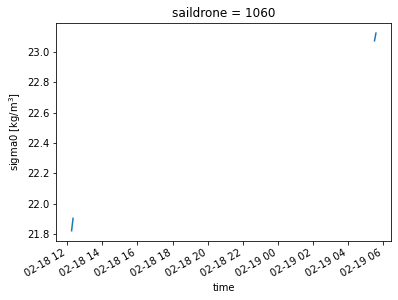

In [109]:
test.sel(saildrone='1060').sigma0.plot()

In [58]:
# condition statement to find at what timepoints the density gradient is larger than the threshold 
array1 = np.where([(subset_nonadcp_resampled.rho_diff >= gradient_threshold_max)])[1]
array2 = np.where([(subset_nonadcp_resampled.rho_diff <= gradient_threshold_min)])[1]


In [59]:
# make values into a list instead of an array 
values_list1 = array1.tolist()
values_list2 = array2.tolist()

In [62]:
values_list2

[373, 373, 383, 383, 384, 385, 386, 391, 396, 396, 397, 405, 406, 407, 935]

In [63]:
# create empty ds lists for appending new datasets to based on the values_list 
dslist_nonadcp = []
dslist_coefs = []
dslist_subset = []
dslist_coefs_nonadcp = []


In [64]:
# define a buffer to select some data before and after the gradient point (aiming for a few km of data)
# buffer value will change based on what horizontal scale you are looking at 
# buffer value refers to number of time points to add on (e.g. if looking at 1 km fronts, the buffer will add ~1km/point 
# of data to the fronts before and after)

buffer = 5

for value in range(len(values_list1)):
    dslist_nonadcp.append(subset_nonadcp_resampled.isel(time=slice(values_list1[value]-buffer,values_list1[value]+buffer)))
    dslist_coefs.append(allcoefs_resampled.isel(time=slice(values_list1[value]-buffer,values_list1[value]+buffer)))
    dslist_subset.append(subset_resampled.isel(time=slice(values_list1[value]-buffer,values_list1[value]+buffer)))
    dslist_coefs_nonadcp.append(coefs_nonadcp_resampled.isel(time=slice(values_list1[value]-buffer,values_list1[value]+buffer)))
    
for value in range(len(values_list2)):
    dslist_nonadcp.append(subset_nonadcp_resampled.isel(time=slice(values_list2[value]-buffer,values_list2[value]+buffer)))
    dslist_coefs.append(allcoefs_resampled.isel(time=slice(values_list2[value]-buffer,values_list2[value]+buffer)))
    dslist_subset.append(subset_resampled.isel(time=slice(values_list2[value]-buffer,values_list2[value]+buffer)))
    dslist_coefs_nonadcp.append(coefs_nonadcp_resampled.isel(time=slice(values_list2[value]-buffer,values_list2[value]+buffer)))
    

In [71]:
len(values_list1 + values_list2)

27

In [72]:
# calculate cumulative distance of fronts 
dslists = [dslist_nonadcp,dslist_subset]
for ds_list in dslists:
    for i in range(len(values_list1 + values_list2)):
                
        cum_dist = CalculateDistance(lon = ds_list[i].sel(saildrone='1060').lon, 
                                 lat = ds_list[i].sel(saildrone='1060').lat)
        ds_list[i]['distance_cum'] = ('time',cum_dist)

In [73]:
# calculate cumulative distance for datasets without saildrone dimension
dslists = [dslist_coefs_nonadcp,dslist_coefs]
for ds_list in dslists:
    for i in range(len(values_list1 + values_list2)):
                
        cum_dist = CalculateDistance(lon = ds_list[i].lon, 
                                 lat = ds_list[i].lat)
        ds_list[i]['distance_cum'] = ('time',cum_dist)

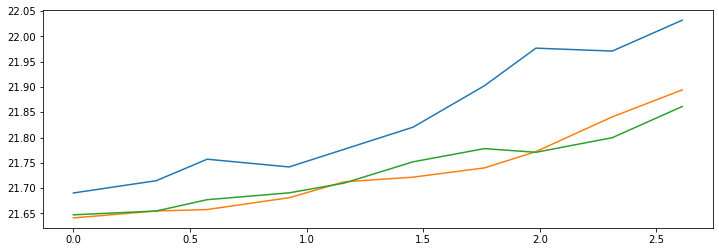

In [75]:
# plot of first front dataset to show differences between saildrone tracks 
figure = plt.figure(figsize=(12,4))
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1060').sigma0)
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1061').sigma0)
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1026').sigma0)

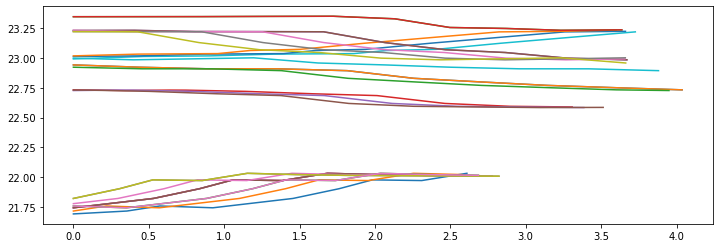

In [76]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(ds_list)):
    plt.plot(dslist_nonadcp[ds].distance_cum,dslist_nonadcp[ds].sel(saildrone='1060').sigma0)

In [84]:
dslist_nonadcp[0]

<xarray.Dataset>
Dimensions:           (time: 10, saildrone: 3)
Coordinates:
  * saildrone         (saildrone) object '1026' '1060' '1061'
  * time              (time) datetime64[ns] 2020-02-18T11:50:00 ... 2020-02-1...
Data variables:
    TEMP_SBE37_MEAN   (time, saildrone) float64 26.91 26.9 26.9 ... 26.91 26.91
    SAL_SBE37_MEAN    (time, saildrone) float64 33.67 33.72 ... 34.19 34.01
    CHLOR_RBR_MEAN    (time, saildrone) float64 0.4918 0.3908 ... 0.358 0.3525
    O2_CONC_RBR_MEAN  (time, saildrone) float64 189.4 192.9 ... 192.7 194.1
    b                 (time, saildrone) float64 -0.008837 ... -0.006473
    sigma0            (time, saildrone) float64 21.65 21.69 ... 22.03 21.89
    distance          (time) float64 414.5 414.9 415.2 ... 416.8 417.2 417.5
    lat               (time, saildrone) float64 9.77 9.766 9.76 ... 9.764 9.759
    lon               (time, saildrone) float64 -56.55 -56.54 ... -56.52 -56.53
    rho_diff          (time, saildrone) float64 0.0009301 0.006924 ... 0.004924
    distance_cum      (time) float64 0.0 0.3549 0.5734 ... 1.983 2.31 2.61

In [ ]:
coefs_density = Coefs_Dataset(subset=subset_nonadcp,
                     variable='sigma0',
                     var1 = 'rho_mean',
                     var2 = 'rhox',
                     var3 = 'rhoy',
                     j=False)

In [22]:
varx = coefs_nonadcp.rhox
vary = coefs_nonadcp.rhoy

In [23]:
# calculate 2D magnitude to get the gradient 
gradient = np.sqrt(varx**2 + vary**2)

In [24]:
gradient

<xarray.DataArray (time: 7201)>
array([1.75033870e-05, 1.74822699e-05, 1.73621348e-05, ...,
       6.24908046e-06, 6.43094348e-06, 6.16784627e-06])
Coordinates:
    longitude  (time) float64 -59.06 -59.06 -59.06 ... -54.85 -54.85 -54.85
    latitude   (time) float64 11.9 11.9 11.9 11.9 ... 9.481 9.481 9.481 9.481
  * time       (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06:30:00

In [25]:
# add gradient to dataset 
varname = 'rho_gradient'
coefs_nonadcp[varname] = gradient 

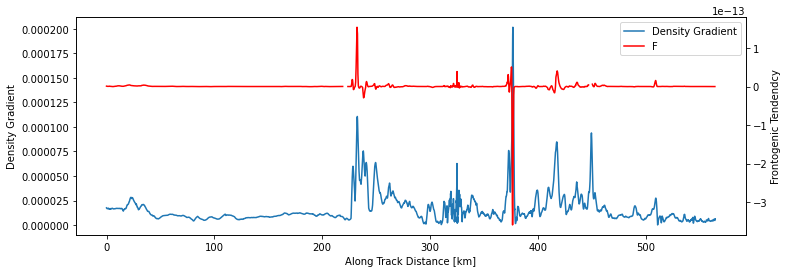

In [26]:
# plot of density gradient and frontogenic tendency 
fig, ax = plt.subplots(figsize=(12,4))

im0, = ax.plot(coefs_nonadcp.distance,coefs_nonadcp.rho_gradient,label='Density Gradient')
twinx = ax.twinx()
im1, = twinx.plot(allcoefs.distance,allcoefs.isel(depth=0).F,color='r',label = 'F')
ax.set_ylabel('Density Gradient')
twinx.set_ylabel('Frontogenic Tendendcy')
ax.set_xlabel("Along Track Distance [km]")
plt.legend(handles=[im0,im1])
# gradient.plot(figsize=(12,4))
# allcoefs.isel(depth=0).F.plot()

In [56]:
# define a sampling interval and find what average distance between points that corresponds to 
resampling_interval = '5MIN'
sw.dist(lat=subset.sel(saildrone='1060').resample(time=resampling_interval).mean(dim='time').lat, 
        lon = subset.sel(saildrone='1060').resample(time=resampling_interval).mean(dim='time').lon,units='km')[0].mean()

0.41049652943585263

In [59]:
subset.distance.values

array([0.00000000e+00, 5.75749540e-01, 1.18228752e+00, ...,
       5.90396687e+02, 5.90877059e+02, 5.91115002e+02])

In [61]:
# resample datasets to resampling interval 
subset_nonadcp_resampled = subset_nonadcp.resample(time=resampling_interval).mean(dim='time')
coefs_nonadcp_resampled = coefs_nonadcp.resample(time=resampling_interval).mean(dim='time')
subset_resampled = subset.resample(time=resampling_interval).mean(dim='time')
allcoefs_resampled = allcoefs.resample(time=resampling_interval).mean(dim='time')


In [85]:
# define gradient threshold 
gradient_threshold = 0.0001

In [94]:
coefs_nonadcp_resampled

<xarray.Dataset>
Dimensions:       (time: 1441)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-15T06:30:00 ... 2020-02-20T06...
Data variables: (12/16)
    b_mean        (time) float64 0.246 0.2463 0.2465 ... 0.3697 0.3698 0.3697
    bx            (time) float64 -5.419e-06 -5.053e-06 ... -1.694e-06 -1.644e-06
    by            (time) float64 -5.244e-06 -5.287e-06 ... -2.136e-06 -2.121e-06
    sal_mean      (time) float64 35.76 35.76 35.76 35.76 ... 36.35 36.35 36.35
    salx          (time) float64 -1.335e-05 -1.26e-05 ... -6.538e-06 -7.201e-06
    saly          (time) float64 -1.083e-05 -1.125e-05 ... -9.83e-06 -1.109e-05
    ...            ...
    rhox          (time) float64 -1.245e-05 -1.161e-05 ... -3.895e-06 -3.777e-06
    rhoy          (time) float64 -1.205e-05 -1.215e-05 ... -4.909e-06 -4.876e-06
    distance      (time) float64 0.1164 0.406 0.6883 1.079 ... 564.2 564.2 564.2
    lat           (time) float64 11.9 11.9 11.9 11.9 ... 9.481 9.481 9.481 9.481
    lon           (time) float64 -59.06 -59.06 -59.05 ... -54.85 -54.85 -54.85
    rho_gradient  (time) float64 1.733e-05 1.681e-05 ... 6.266e-06 6.168e-06

In [100]:
# condition statement to find at what timepoints the density gradient is larger than the threshold 
array = np.where([coefs_nonadcp_resampled.rho_gradient >= gradient_threshold])[1]

In [101]:
array

array([384, 385, 931, 932, 933, 934, 935, 936, 937, 938])

In [90]:
# make values into a list instead of an array 
values_list = array.tolist()

AttributeError: 'tuple' object has no attribute 'tolist'

In [88]:
values_list

[384, 385, 931, 932, 933, 934, 935, 936, 937, 938]

In [67]:
# create empty ds lists for appending new datasets to based on the values_list 
dslist_nonadcp = []
dslist_coefs = []
dslist_subset = []
dslist_coefs_nonadcp = []


In [68]:
# define a buffer to select some data before and after the gradient point (aiming for a few km of data)
# buffer value will change based on what horizontal scale you are looking at 
# buffer value refers to number of time points to add on (e.g. if looking at 1 km fronts, the buffer will add ~1km/point 
# of data to the fronts before and after)

buffer = 5

for value in range(len(values_list)):
    dslist_nonadcp.append(subset_nonadcp_resampled.isel(time=slice(values_list[value]-buffer,values_list[value]+buffer)))
    dslist_coefs.append(allcoefs_resampled.isel(time=slice(values_list[value]-buffer,values_list[value]+buffer)))
    dslist_subset.append(subset_resampled.isel(time=slice(values_list[value]-buffer,values_list[value]+buffer)))
    dslist_coefs_nonadcp.append(coefs_nonadcp_resampled.isel(time=slice(values_list[value]-buffer,values_list[value]+buffer)))
    

In [69]:
# calculate cumulative distance of fronts 
dslists = [dslist_nonadcp,dslist_subset]
for ds_list in dslists:
    for i in range(len(values_list)):
                
        cum_dist = CalculateDistance(lon = ds_list[i].sel(saildrone='1060').lon, 
                                 lat = ds_list[i].sel(saildrone='1060').lat)
        ds_list[i]['distance_cum'] = ('time',cum_dist)

In [70]:
# calculate cumulative distance for datasets without saildrone dimension
dslists = [dslist_coefs_nonadcp,dslist_coefs]
for ds_list in dslists:
    for i in range(len(values_list)):
                
        cum_dist = CalculateDistance(lon = ds_list[i].lon, 
                                 lat = ds_list[i].lat)
        ds_list[i]['distance_cum'] = ('time',cum_dist)

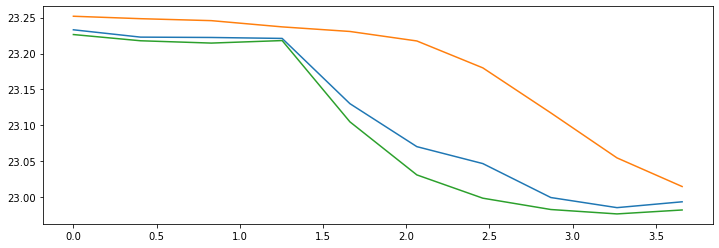

In [71]:
# plot of first front dataset to show differences between saildrone tracks 
figure = plt.figure(figsize=(12,4))
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1060').sigma0)
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1061').sigma0)
plt.plot(dslist_nonadcp[0].distance_cum,dslist_nonadcp[0].sel(saildrone='1026').sigma0)

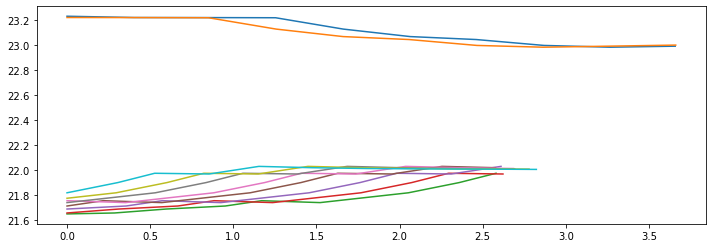

In [72]:
# all the fronts and their distances plotted together 
figure = plt.figure(figsize=(12,4))
for ds in range(len(ds_list)):
    plt.plot(dslist_nonadcp[ds].distance_cum,dslist_nonadcp[ds].sel(saildrone='1060').sigma0)

In [75]:
6e-4 * 86400  # vertical velocity in meters per day estimate 

51.839999999999996

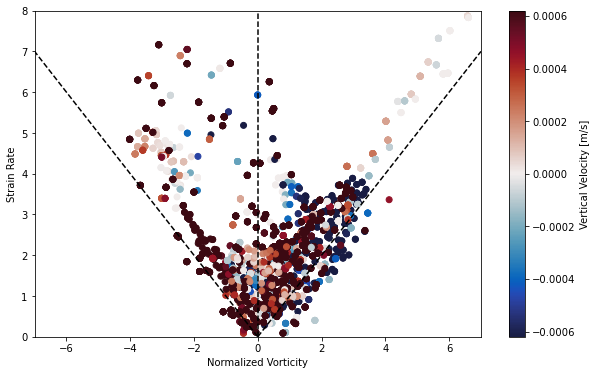

In [73]:
# scatter plot of voriicity vs strain, with vertical velocity colored in the points 
fig = plt.figure(figsize = (10,6))
vmin = -0.00062
vmax = 0.00062
for ds in range(len(dslist_coefs)):
    # fig = plt.figure(figsize = (10,6))
    x = dslist_coefs[ds].vort
    y = dslist_coefs[ds].strain
    plt.scatter(x,y,c=dslist_coefs[ds].w,cmap=cmocean.cm.balance,vmin=vmin,vmax=vmax)
    plt.xlabel('Normalized Vorticity')
    plt.ylabel('Strain Rate')
    
plt.colorbar(label='Vertical Velocity [m/s]')

xmin = -7
xmax = 7
ymin = 0
ymax = 8
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
# plot 1:1 lines 
plt.plot([0, xmax], [0, xmax], 'k',linestyle='dashed')
plt.plot([0, xmin], [0, -xmin], 'k',linestyle='dashed')
#plot vertical line at zero vorticity
plt.vlines(x=0,ymax=ymax,ymin=ymin,color='k',linestyle='dashed')

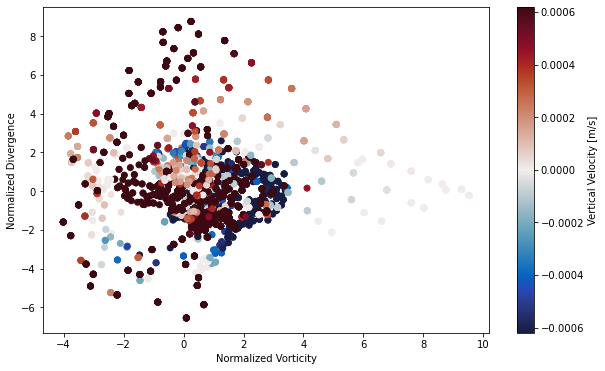

In [76]:
# scatter plot of vorticity and divergence with vertical velocity colored in the points 
fig = plt.figure(figsize = (10,6))
vmin = -0.00062
vmax = 0.00062
for ds in range(len(dslist_coefs)):
    plt.scatter(dslist_coefs[ds].vort,dslist_coefs[ds].div,c=dslist_coefs[ds].w,cmap=cmocean.cm.balance,
                vmin = vmin,vmax = vmax)
plt.xlabel('Normalized Vorticity')
    # plt.xlim(-7,7)
plt.ylabel('Normalized Divergence')
    # plt.ylim(-7,7)
plt.colorbar(label='Vertical Velocity [m/s]')

<function matplotlib.pyplot.show(close=None, block=None)>

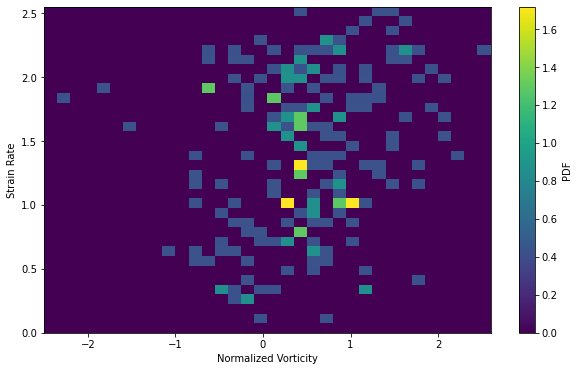

In [77]:
# JPDF vorticity vs. strain - this is often not coming out with the classic v-shape that the scatter plot has - how come??
fig = plt.figure(figsize=(10,6))
dbins, bmin, bmax = 0.15, -2.5, 2.5
binsx=np.arange(bmin,bmax+dbins,dbins)
bins_s=np.arange(0,bmax+dbins/2,dbins/2)

for ds in range(len(dslist_coefs)):
    plt.hist2d(dslist_coefs[ds].vort.values.flatten(),dslist_coefs[ds].strain.values.flatten(),bins=[binsx,bins_s],density=True)
    
plt.colorbar(label = 'PDF')
plt.xlabel('Normalized Vorticity')
plt.ylabel('Strain Rate')
    
plt.show

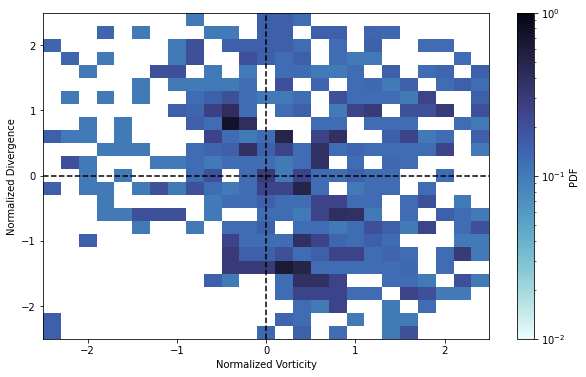

In [74]:
# JPDF of vorticity and divergence with a log scale - need to mess around with binning / log scale 
d = 0.2
fig = plt.figure(figsize=(10,6))

dbins=dbins
bmin=bmin
bmax=bmax
vmin = 0.01
vmax = 1


binsvort0 = np.arange(bmin,bmax+d,d)
binsdiv0 = np.arange(bmin,bmax+d,d)

for ds in range(len(dslist_coefs)):
    hist_vort_div0 = plt.hist2d(dslist_coefs[ds].vort.values.flatten(),
                                dslist_coefs[ds].div.values.flatten(),
                                bins=[binsvort0,binsdiv0],density=True,cmap=cmocean.cm.ice_r,norm=LogNorm(vmin=vmin,vmax=vmax))
plt.plot([bmin,bmax],[0,0],'--',color='k')
plt.plot([0,0],[bmin,bmax],'--',color='k')
plt.xlabel('Normalized Vorticity')
plt.ylabel('Normalized Divergence')

fig.colorbar(hist_vort_div0[3],label='PDF')

#### TO DO: 

1. Consider how to resample the dataset by distance, is this possible?
    - xarray's resample only works with time data so would need to find another way 
    - resampling by time and adding a buffer to the front points results in front sections of different horizontal distances because the SDs don't travel the same distance in the same amount of time depending on how they are moving (e.g. takes longer to travel 5 km upwind than 5 km on a broad reach) 
    
2. Find the best way to save the lists of datasets 

3. Do various analyses for different front scales (maybe 1 - 20 km) 

4. Create single PDFs for vort, div, strain 

